# 0. Problem description
--------------------------
I've got this dataset of financial time series from my freinds at TenViz who's job is the magic of predicting stock market movements. The problem was formulated as follows:
> ... to predict *target_class* based on values of *target_variable* & available features (dataset 'test_task_data.csv'). Before building a classifier, please pay attention to the nature of features and specific aspects of working with time series. Also, you can use *target_values* to derive useful information and additional features. As a train set use dataset from 2012-01-01 till 2016-12-31, as a test set used from 2017-01-02 till 2018-06-19. Finally, evaluate your model & provide analysis with short comments.
> The results of the work should contain:
> * Description of the steps of the solution of the task.
> * Runnable implementation code in Python.
> * PDF with the charts

### In this notebook I review the raw time series data and build an online learing classifier based on a stacked LSTM RNN, which can be applied to any new data going forward.

## Contents:
1. [Load and Review Data](#1)
2. [Feature Engineering](#2)
3. [LSTM Model - Batch Training and Predictiction](#3)
4. [APPENDIX - EDA for Individual Time Series](#4)

In [30]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap
import statsmodels.api as sm  # seasonal trend decomposition
from statsmodels.graphics import tsaplots   # autocorrelation

%matplotlib inline

# <a name="1"></a> 1. Load and Review Data
------------------

In [31]:
# Import data, convert string dates to 'datetime64' and set the date column as index:
df = pd.read_csv('../input/test_task_data.csv',
                 parse_dates=['date'],
                 infer_datetime_format=True,
                 index_col='date',
                 thousands=',',
                 decimal='.')

In [32]:
#  Review the general info on data, paying attention to missing values and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1687 entries, 2012-01-02 to 2018-06-19
Data columns (total 19 columns):
feature_1       1687 non-null float64
feature_2       1687 non-null float64
feature_3       1687 non-null float64
feature_4       1687 non-null float64
feature_5       1479 non-null float64
feature_6       1687 non-null float64
feature_7       1687 non-null float64
feature_8       1687 non-null float64
feature_9       1687 non-null float64
feature_10      1687 non-null float64
feature_11      1687 non-null float64
feature_12      1687 non-null float64
feature_13      1687 non-null float64
feature_14      1687 non-null float64
feature_15      1687 non-null float64
feature_16      1687 non-null float64
Unnamed: 17     0 non-null float64
target_value    1687 non-null float64
target_class    1687 non-null int64
dtypes: float64(18), int64(1)
memory usage: 263.6 KB


In [33]:
# Let's remove the empty column and look at some examples of data:
df = df.drop(columns='Unnamed: 17')
print(f'data shape = {df.shape}')
df.head()

data shape = (1687, 18)


feature_1  feature_2      ...       target_value  target_class
date                                  ...                                 
2012-01-02    1997.00     107.38      ...          59.324325             0
2012-01-03    2054.50     112.13      ...          60.971989             0
2012-01-04    2041.25     113.70      ...          61.100708             0
2012-01-05    2013.00     112.74      ...          60.808938             0
2012-01-06    2045.75     113.06      ...          60.448514             0

[5 rows x 18 columns]

In [34]:
# It appears that 'feature_5' has missing values up to 2012-10-18
# let's fill them backwards
df.feature_5 = df.feature_5.fillna(method='bfill')

In [35]:
# Basic statistics of the data:
df.describe()

feature_1    feature_2      ...       target_value  target_class
count  1687.000000  1687.000000      ...        1687.000000   1687.000000
mean   1874.441766    78.308648      ...          68.492905      0.483106
std     208.258411    28.412734      ...           7.947151      0.499863
min    1432.500000    27.880000      ...          48.508190      0.000000
25%    1738.625000    51.705000      ...          63.116075      0.000000
50%    1877.000000    68.580000      ...          67.500964      0.000000
75%    2030.875000   108.395000      ...          73.274163      1.000000
max    2539.500000   126.220000      ...          91.048496      1.000000

[8 rows x 18 columns]

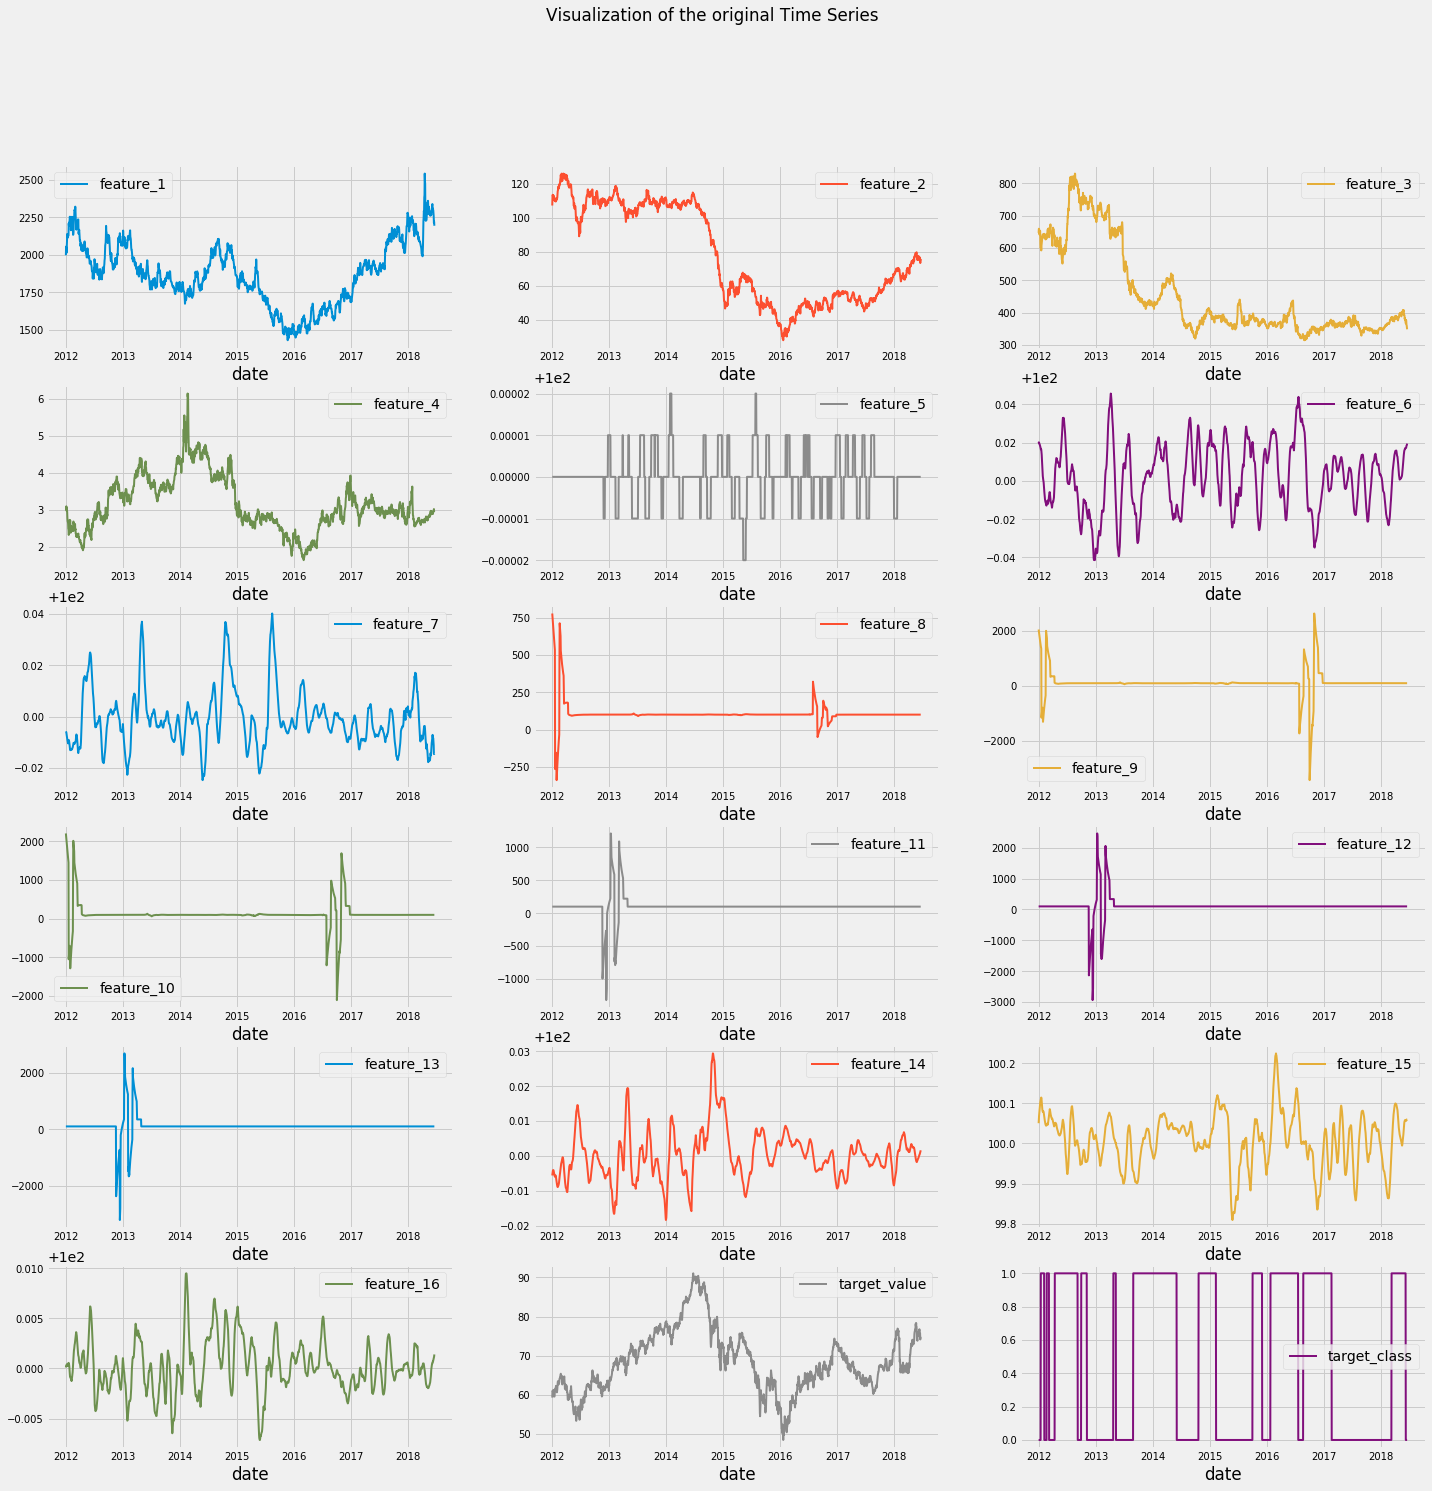

In [36]:
# Plot the time series
plt.style.use('fivethirtyeight')
df.plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

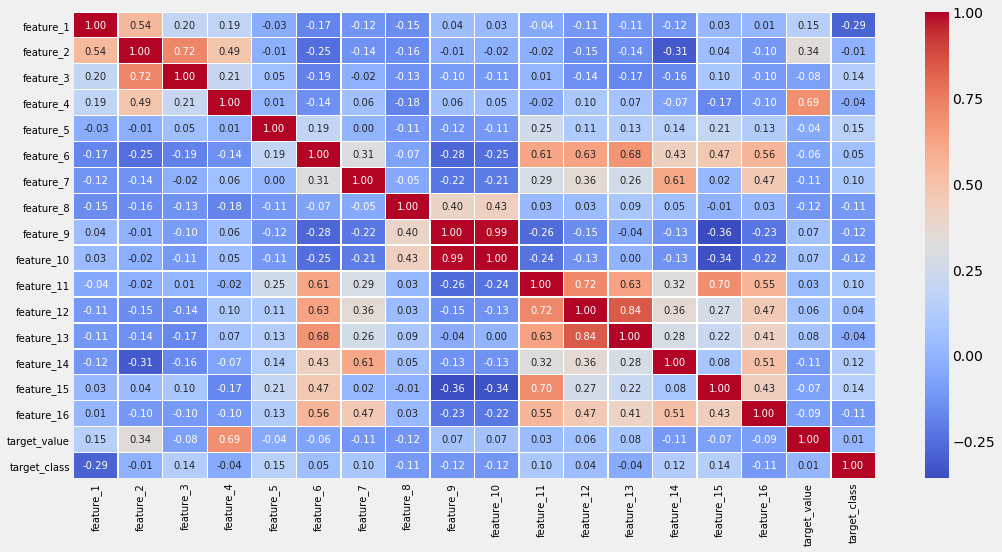

In [37]:
# Let's also draw a heatmap visualization of the correlation matrix
corr_matrix = df.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## What do we have from the raw data review?
* Exploratory Data Analysis of individual time series is visualized in the [APPENDIX](#index) below.
* The raw data contain stochastic time series, including 'target_value'. Predicting/ making classification based on stochastic variable values may force the model to learn the 'persistence' mode (i.e. yhat(t+1) = y(t)), resulting in little predictive power. Therefore, some sort of 'normalizing' the features time series is required. 
* The raw data are weakly correleted with the target_value and the target_class and among each other with rare exceptions. The predictive power could be in temporal effects. 
* The raw data are at different scales, therefore the normalization of the features should rescale the data to ensure efficient learning of NN models.
* The raw data contain 'noise', which we are better to remove, at least on the training dataset for more efficient pre-training of the model. As the test dataset will be used in emulating an online learning of the model, where noise cleaning is not practical, I'm not going to remove noise from the test data.

Possible nature | TS_name | Description | Transformation | Rescaling after transformation
:---: | :-- | :-- | :-- | :--
class | target_class | binary (48%-1s, 52%-0s) | None | None
stock index or indicator like RSI | [target_value](#target_value) | unimodal, bell-shaped, skewed to the right, stochastic trend with values in [48, 91], order +2 autocorr | pc_change or log diff | Standard
stock index | [feature_1](#feature_1) | unimodal, bell-shaped, slightly skewed to the right, stochastic trend with values in [1432, 2539], order +2 autocorr | pc_change or log diff | Standard
stock index | [feature_2](#feature_2) | bimodal, stochastic trend with values in [27, 126 ], order +2 autocorr | pc_change or log diff | Standard or MinMax
stock index | [feature_3](#feature_3) | unimodal, strongly skewed to the right,  stochastic trend with values in [315, 830], order +2 autocorr  | pc_change or log diff | Standard or MinMax
stock index | [feature_4](#feature_4) | unimodal, skewed to the right,  stochastic trend with values in [1, 6 ], order +2 autocorr | pc_change or log diff | Standard
technical indicator | [feature_5](#feature_5) | unimodal, 5 descrete values  in [100+-0.00002], ordr +2 autocorr |  pc_change or log diff | Standard
technical indicator | [feature_6](#feature_6) | unimodal, bell-shaped, ranging in [100+- 0.04], order +2 autocorr | pc_change or log diff | Standard
technical indicator | [feature_7](#feature_7) | unimodal, skewed to the right, ranging in [100+-0.04], order -29/+31 autocorr  | pc_change or log diff | Standard
technical indicator | [feature_8](#feature_8) | ranging around 100, occasional spikes in range [-340, +780] - [Q1'12, Q4'16], order 2 autocorr, negative values! | pc_change | Standard or MinMax
technical indicator | [feature_9](#feature_9) | ranging around 100, occasional spikes in range [-3413, +2626] - [Q1'12, Q4'16], order 2 autocorr, negative values! | pc_change | Standard or MinMax
technical indicator | [feature_10](#feature_10) | ranging around 100, occasional spikes in range [-2104, +2206] - [Q1'12, Q4'16], order 2 autocorr, negative values! | pc_change | Standard or MinMax
technical indicator | [feature_11](#feature_11) | ranging around 100, occasional spikes in range [-1321, +1213 ] - [Q4'12-Q1'13], order 2 autocorr, negative values! | pc_change | Standard or MinMax
technical indicator | [feature_12](#feature_12) | ranging around 100, occasional spikes in range [-2933, +2462 ] - [Q4'12-Q1'13], order 2 autocorr, negative values! | pc_change | Standard or MinMax
technical indicator | [feature_13](#feature_13) | ranging around 100, occasional spikes in range [-3206, +2687 ] - [Q4'12-Q1'13], order 2 autocorr, negative values! | pc_change | Standard or MinMax
technical indicator (oscillator) | [feature_14](#feature_14) | unimodal, skewed to the right, ranging in  [100+-0.02], autocorr +32 | pc_change or log diff | Standard
technical indicator (oscillator) | [feature_15](#feature_15) | unimodal, bell-shaped, skewed to the left, ranging in [100+-0.02], autocorr -38 | pc_change or log diff | Standard
technical indicator (oscillator) | [feature_16](#feature_16) | unimodal, bell-shaped, ranging in [100+-0.01], autocorr +14 | pc_change or log diff | Standard

In [38]:
# Run time series decomposition to extract and remove noise from training features
dict_noise = {}
for ts in df.loc[:, 'feature_1':'target_value']:
    ts_decomp = sm.tsa.seasonal_decompose(df[ts])
    dict_noise[ts] = ts_decomp.resid

# Convert to a DataFrame
df_noise = pd.DataFrame.from_dict(dict_noise).fillna(method='bfill')
df_cleaned = df.loc[:, 'feature_1':'target_value'].sub(df_noise)
df_cleaned.head()

feature_1   feature_2      ...       feature_16  target_value
date                                     ...                               
2012-01-02  1986.750832  105.429047      ...       100.000070     58.766075
2012-01-03  2044.250832  110.179047      ...       100.000230     60.413740
2012-01-04  2031.000832  111.749047      ...       100.000280     60.542458
2012-01-05  2048.411306  112.855990      ...       100.000344     60.842893
2012-01-06  2064.856469  113.156085      ...       100.000373     60.897619

[5 rows x 17 columns]

# <a name="2"></a> 2. Feature Engineering
-------

In [39]:
# Split train and test data
train_features = df_cleaned.loc['2012-01-02':'2016-12-31', 'feature_1':'target_value']
train_labels = df.loc['2012-01-02':'2016-12-31', 'target_class']

test_features = df.loc['2017-01-02':'2018-06-19', 'feature_1':'target_value']
test_labels = df.loc['2017-01-02':'2018-06-19', 'target_class']

# I want to use a T-days window of input data for predicting target_class
# It means I need to prepend (T-1) last train records to the 1st test window
T = 30  # my choice of the timesteps window

prepend_features = train_features.iloc[-(T-1):]
test_features = pd.concat([prepend_features, test_features], axis=0)

train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((1305, 17), (1305,), (411, 17), (382,))

In [40]:
# Create sequences of T timesteps (=sliding window)
# Normalize sequences X = X/X_0-1, where X_0 is 1st timestep in the window:
X_train, y_train = [], []
for i in range(train_labels.shape[0] - (T-1)):
    X_train.append(train_features.iloc[i:i+T].div(train_features.iloc[i]).sub(1).values)
    y_train.append(train_labels.iloc[i + (T-1)])
X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1)
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

X_test, y_test = [], []
for i in range(test_labels.shape[0]):
    X_test.append(test_features.iloc[i:i+T].div(test_features.iloc[i]).sub(1).values)
    y_test.append(test_labels.iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,1)  

print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

Train data dimensions: (1276, 30, 17), (1276, 1)
Test data dimensions: (382, 30, 17), (382, 1)


# <a name="3"></a> 3. LSTM Model - Batch Training and Predictiction
-------------------------

In [41]:
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

layers=[16, 16, 16, 1], train_examples=1276, test_examples=382
batch = 256, timesteps = 30, features = 17, epochs = 50
lr = 0.1, lambda = 0.05, dropout = 0.0, recurr_dropout = 0.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 30, 16)            2176      
_________________________________________________________________
batch_normalization_31 (Batc (None, 30, 16)            64        
_________________________________________________________________
lstm_32 (LSTM)               (None, 30, 16)            2112      
_________________________________________________________________
batch_normalization_32 (Batc (None, 30, 16)            64        
_________________________________________________________________
lstm_33 (LSTM)               (None, 16)                2112      
_________________________________________________________________
batch_normalization_33 (Batc

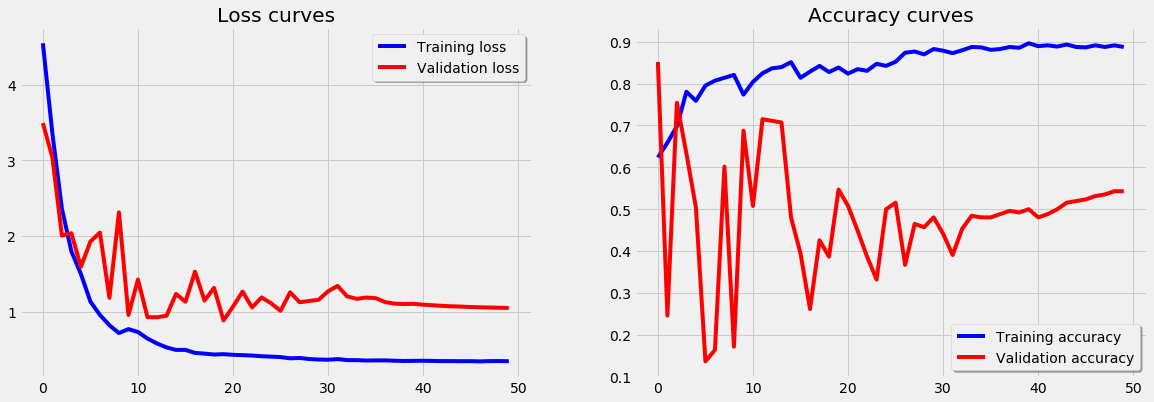

Fixed model test score = 64.92%


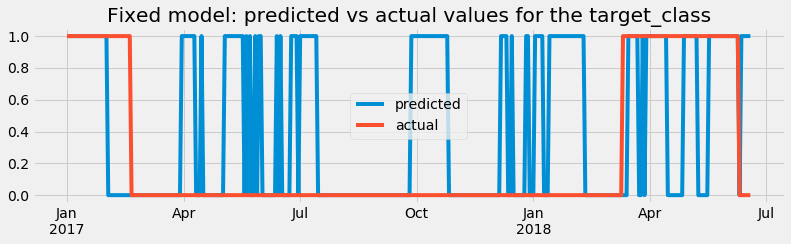

In [70]:
# Let's make a list of CONSTANTS for modelling:
LAYERS = [16, 16, 16, 1]             # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
BATCH = 256                          # batch size
EPOCH = 50                           # number of epochs
LR = 1e-1                            # learning rate of the gradient descent
LAMBD = 5e-2                         # lambda in L2 regularizaion
DP = 0.00                            # dropout rate
RDP = 0.00                           # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T,N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False))
model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(loss='binary_crossentropy', metrics=['accuracy'],
              optimizer=Adam(lr=LR))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                           patience=10, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=False)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH,
                    validation_split=0.2, shuffle=True,verbose=0,
                    callbacks=[lr_decay])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_acc = History.history['acc'][-1]    #model.evaluate(X_train, y_train, batch_size=M_TRAIN)
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=M_TEST)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 2)}%')
print(f'fixed model test score = {round(test_acc * 100, 2)}%')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['acc'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_acc'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

# Plot predictions vs actual labels for fixed model
index = pd.date_range(start='2017-01-02', end='2018-06-19', freq='B')
fixed_predict = np.round_(model.predict_on_batch(X_test))
fixed_score = np.sum(fixed_predict == y_test) / y_test.shape[0]
print(f'Fixed model test score = {round(fixed_score*100, 2)}%')
dff = pd.DataFrame({'predicted':fixed_predict.squeeze(), 'actual':y_test.squeeze()}, index=index)
ax = dff.plot(figsize=(12,3))
ax.set_title('Fixed model: predicted vs actual values for the target_class')
plt.show()

In [ ]:
# Define online model with the pre-trained weights from the fixed model
# The main reason I reinstantiate the model is to restart decayed learning rate:
start = time()
config, weights = model.get_config(), model.get_weights()
online_model = Sequential.from_config(config)
online_model.set_weights(weights)
online_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=LR))
print(f'Online model instantiated in {time() - start:.2f} secs')

# Online training (update model with each new data available):
predictions = []
start = time()
for t in range(y_test.shape[0]):
    x = X_test[t].reshape(-1,T,N)  # a "new" input is available
    y_hat = np.round_(model.predict_on_batch(x)) # predict on the "new" input
    predictions.append(y_hat)  # save predictions
    y = y_test[t].reshape(-1,1)   # a "new" label is available
    model.train_on_batch(x, y)  # runs a single gradient update 
print(f'Online learning completed in {time() - start:.2f} secs')

# Evaluation of the predictions with online learning
online_predict = np.array(predictions).reshape(-1,1)
online_score = np.sum(online_predict == y_test) / y_test.shape[0]
print(f'Online model test score = {round(online_score*100, 2)}%')

# Plot predictions vs actual labels:
index = pd.date_range(start='2017-01-02', end='2018-06-19', freq='B')
dfo = pd.DataFrame({'predicted':online_predict.squeeze(), 'actual':y_test.squeeze()}, index=index)
ax = dfo.plot(figsize=(12,3))
ax.set_title('Online model: predicted vs actual values for the target_class')
plt.show()

# <a name="4"></a> 4. APPENDIX - Exploratory Data Analysis for Individual Time Series
### <a name="index"></a> INDEX:

Reference | Reference | Reference
:-- | :-- | :--
[EDA Function](#eda_function) | [A-5. feature_5](#feature_5) | [A-11. feature_11](#feature_11) 
[A-0. target_value](#target_value) | [A-6. feature_6](#feature_6)  | [A-12. feature_12](#feature_12) 
[A-1. feature_1](#feature_1) | [A-7. feature_7](#feature_7) | [A-13. feature_13](#feature_13) 
[A-2. feature_2](#feature_2) | [A-8. feature_8](#feature_8) | [A-14. feature_14](#feature_14) 
[A-3. feature_3](#feature_3) | [A-9. feature_9](#feature_9) | [A-15. feature_15](#feature_15) 
[A-4. feature_4](#feature_4) | [A-10. feature_10](#feature_10) | [A-16. feature_16](#feature_16) 

<h1 id="eda_function"> EDA Function </h1>

In [44]:
# Let's define a EDA function for repeated calls on individual time series:
def eda(df_name, ts_name):
    """ 
    Inputs: df_name - name of the dataframe
            ts_name - name of the time series in the dataframe
    Outputs: EDA statistics and plots for individual time series in df_name
    """
    # Statistics
    print(f'Statistic of {ts_name} time series')
    print(df_name[ts_name].describe())
    
    # Plotting
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(24,24))
    fig.suptitle(f'Visualization of the "{ts_name}" time series', fontsize=24)
        
    # Observed values of the time series against target_class values
    df_name[ts_name].plot(ylim=[df_name[ts_name].min(), df_name[ts_name].max()],
                          linewidth=2, ax=axs[0,0])
    axs[0,0].set_title('Observed values (red/green where target_class=0/1)')
    axs[0,0].set_xlabel('')
    axs[0,0].fill_between(df_name.index, df_name[ts_name], 
                          where=(df_name.target_class==0),
                          facecolor='red', alpha=0.5)
    axs[0,0].fill_between(df_name.index, df_name[ts_name], 
                          where=(df_name.target_class==1),
                          facecolor='green', alpha=0.5)
    axs[0,0].axvline('2017-01-01', color='red', linestyle='dashed')
    
    # Seasonality, trend and noise in time series data
    decomp = sm.tsa.seasonal_decompose(df_name[ts_name])
    decomp.trend.plot(linewidth=2, ax=axs[0,1])
    axs[0,1].set_title('Trend values')
    axs[0,1].set_xlabel('')
    decomp.seasonal.plot(linewidth=2, ax=axs[1,0])
    axs[1,0].set_title('Seasonal values')
    axs[1,0].set_xlabel('')
    decomp.resid.plot(linewidth=2, ax=axs[1,1])
    axs[1,1].set_title('Residual values')
    axs[1,1].set_xlabel('')
    
    # Distribution of values of time series
    df_name[ts_name].plot.hist(bins=30, ax=axs[2,0])
    axs[2, 0].set_title('Histogram')
    df_name[[ts_name]].boxplot(ax=axs[2,1])
    axs[2, 1].set_title('Boxplot')
        
    # Autocorrelation of time series
    tsaplots.plot_acf(df_name[ts_name], lags=40, ax=axs[3,0])
    tsaplots.plot_pacf(df_name[ts_name], lags=40, ax=axs[3,1])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# <a name="target_value"></a> A-0. target_value 
[Back to INDEX](#index)

Statistic of target_value time series
count    1687.000000
mean       68.492905
std         7.947151
min        48.508190
25%        63.116075
50%        67.500964
75%        73.274163
max        91.048496
Name: target_value, dtype: float64


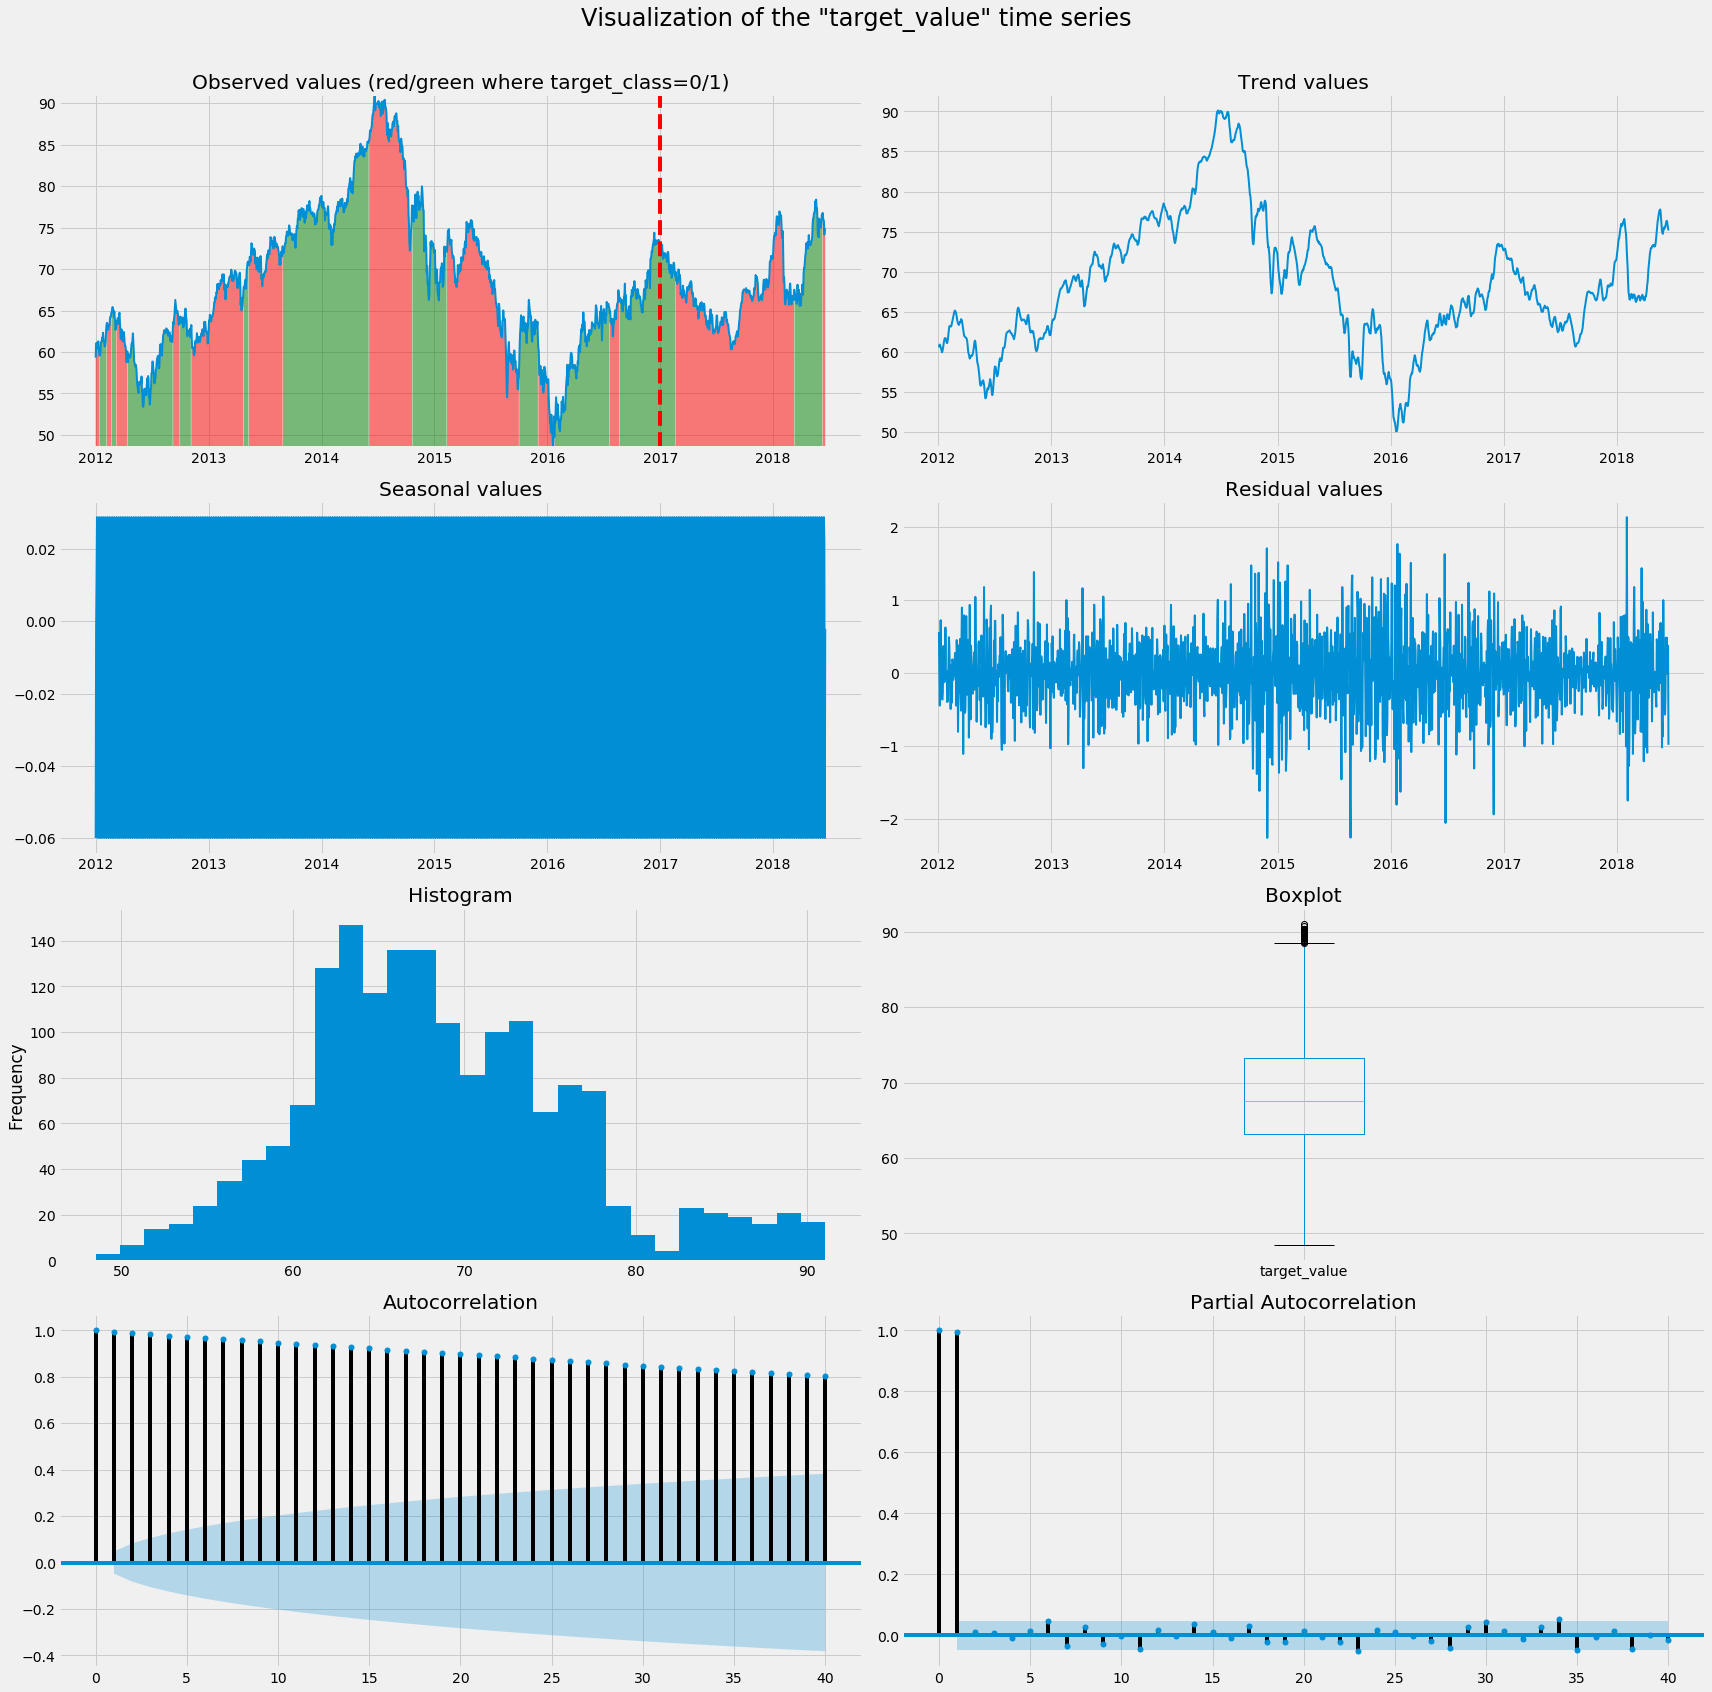

In [45]:
# Call EDA function to explore the time series
eda(df, 'target_value')


### Conclusion: 
* **target_value** is unimodal bell-shaped (slightly skewed to the right); 
* decomposed into trend and stochastic noise;
* percentage change is likely to have stationarity property
* alternative - log transformation of the variable
* it is possible to apply z-score standartization (sklearn StandardScaler)

# <a name="feature_1"></a> A-1. feature_1
[Back to INDEX](#index)

Statistic of feature_1 time series
count    1687.000000
mean     1874.441766
std       208.258411
min      1432.500000
25%      1738.625000
50%      1877.000000
75%      2030.875000
max      2539.500000
Name: feature_1, dtype: float64


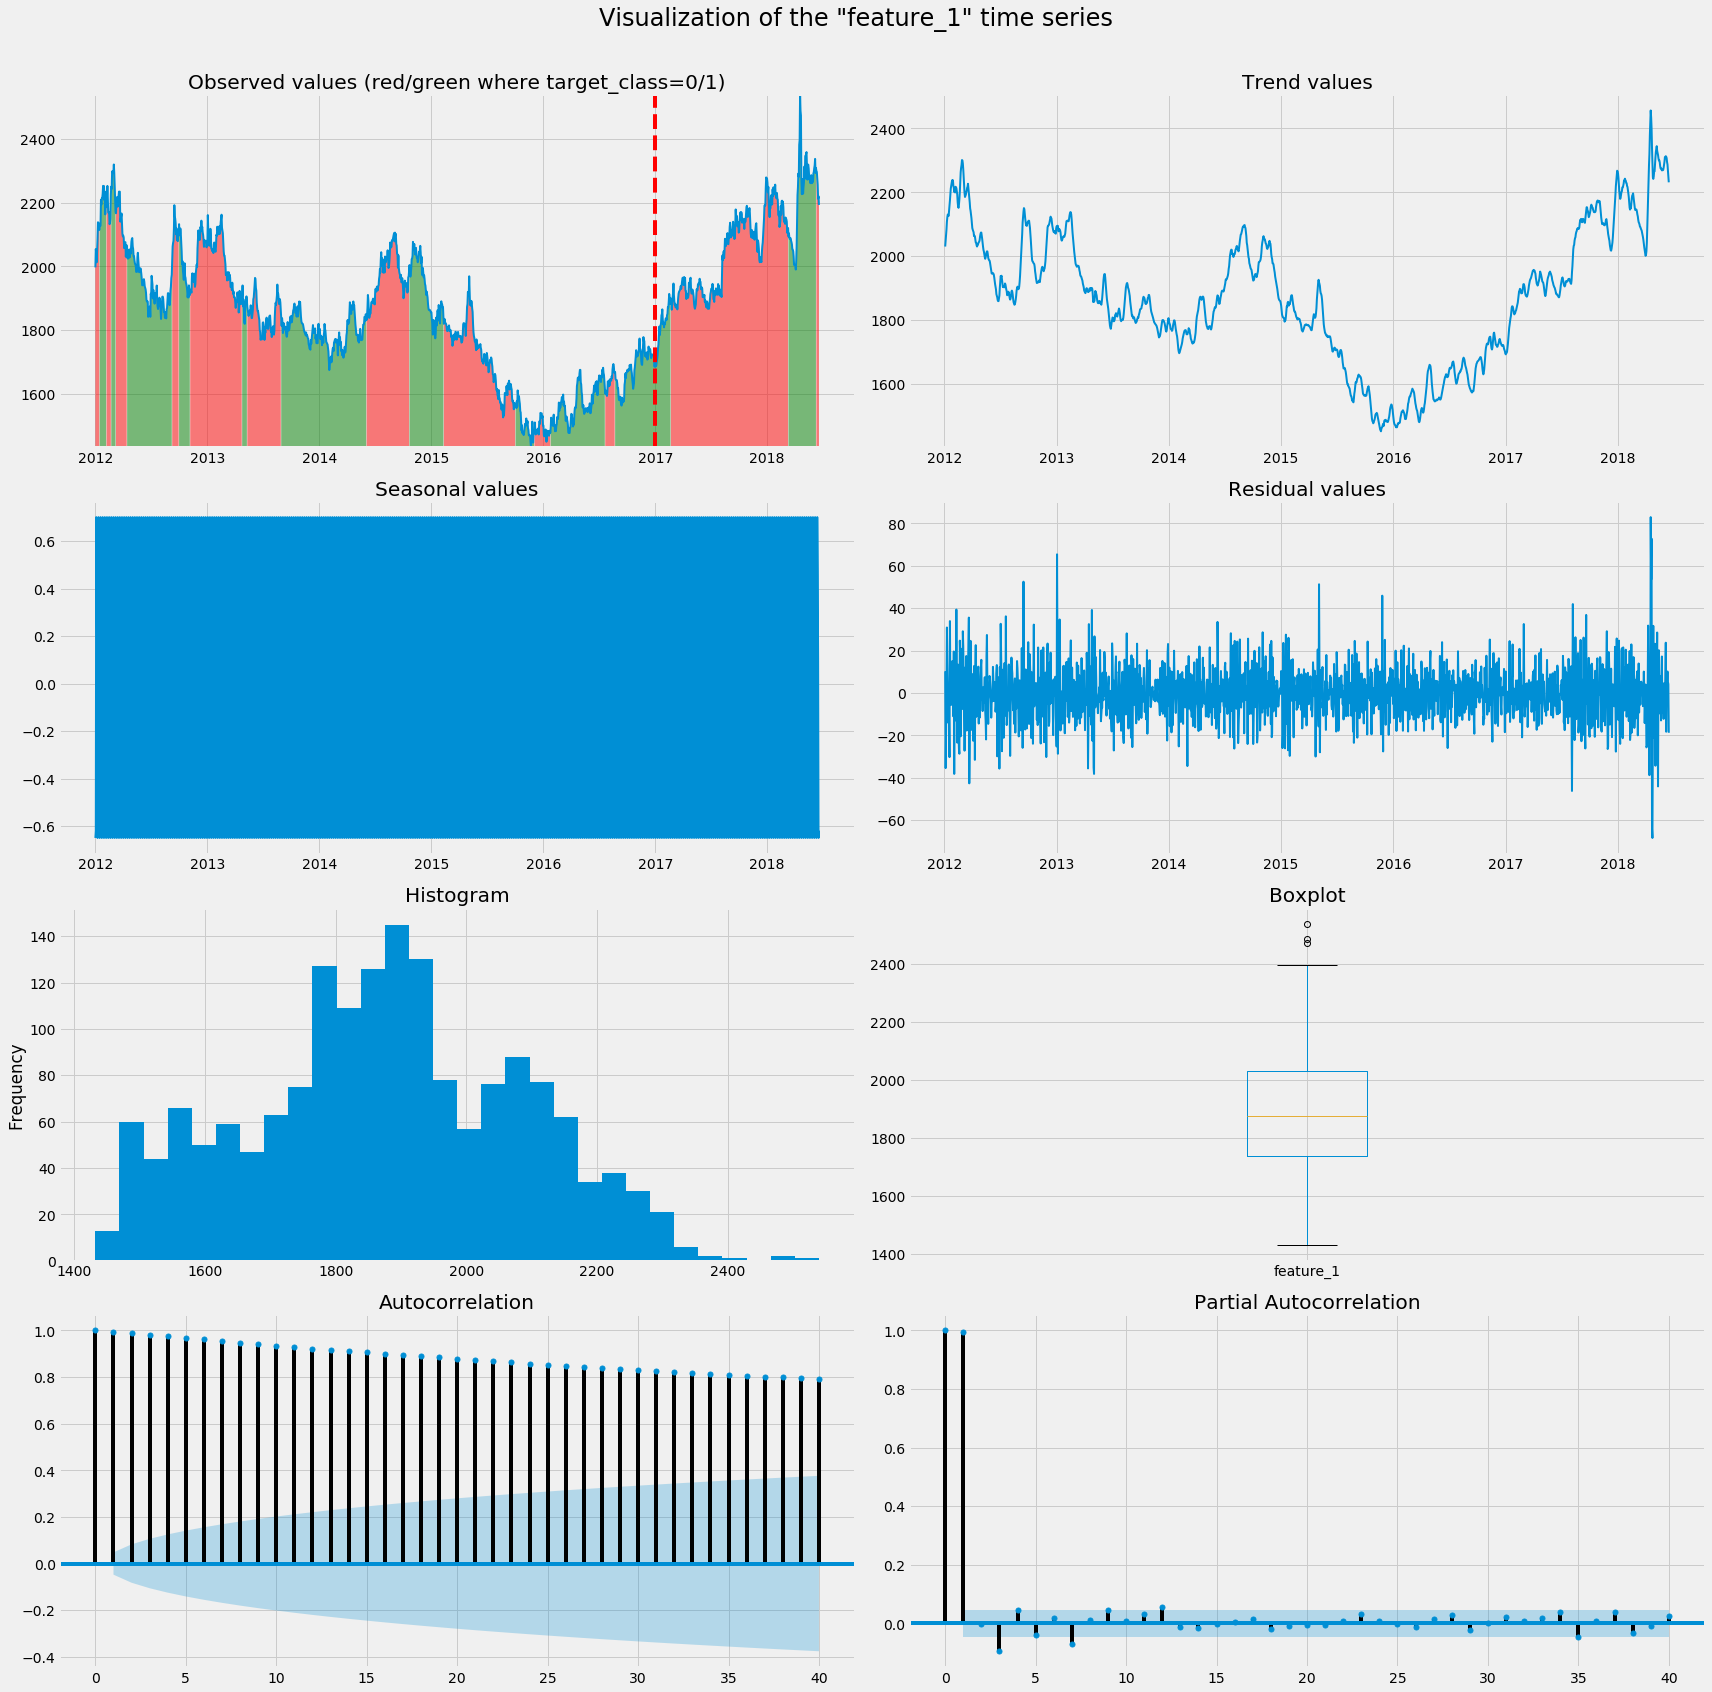

In [46]:
# Call EDA function to explore the time series
eda(df, 'feature_1')

# <a name="feature_2"></a> A-2. feature_2
[Back to INDEX](#index)

Statistic of feature_2 time series
count    1687.000000
mean       78.308648
std        28.412734
min        27.880000
25%        51.705000
50%        68.580000
75%       108.395000
max       126.220000
Name: feature_2, dtype: float64


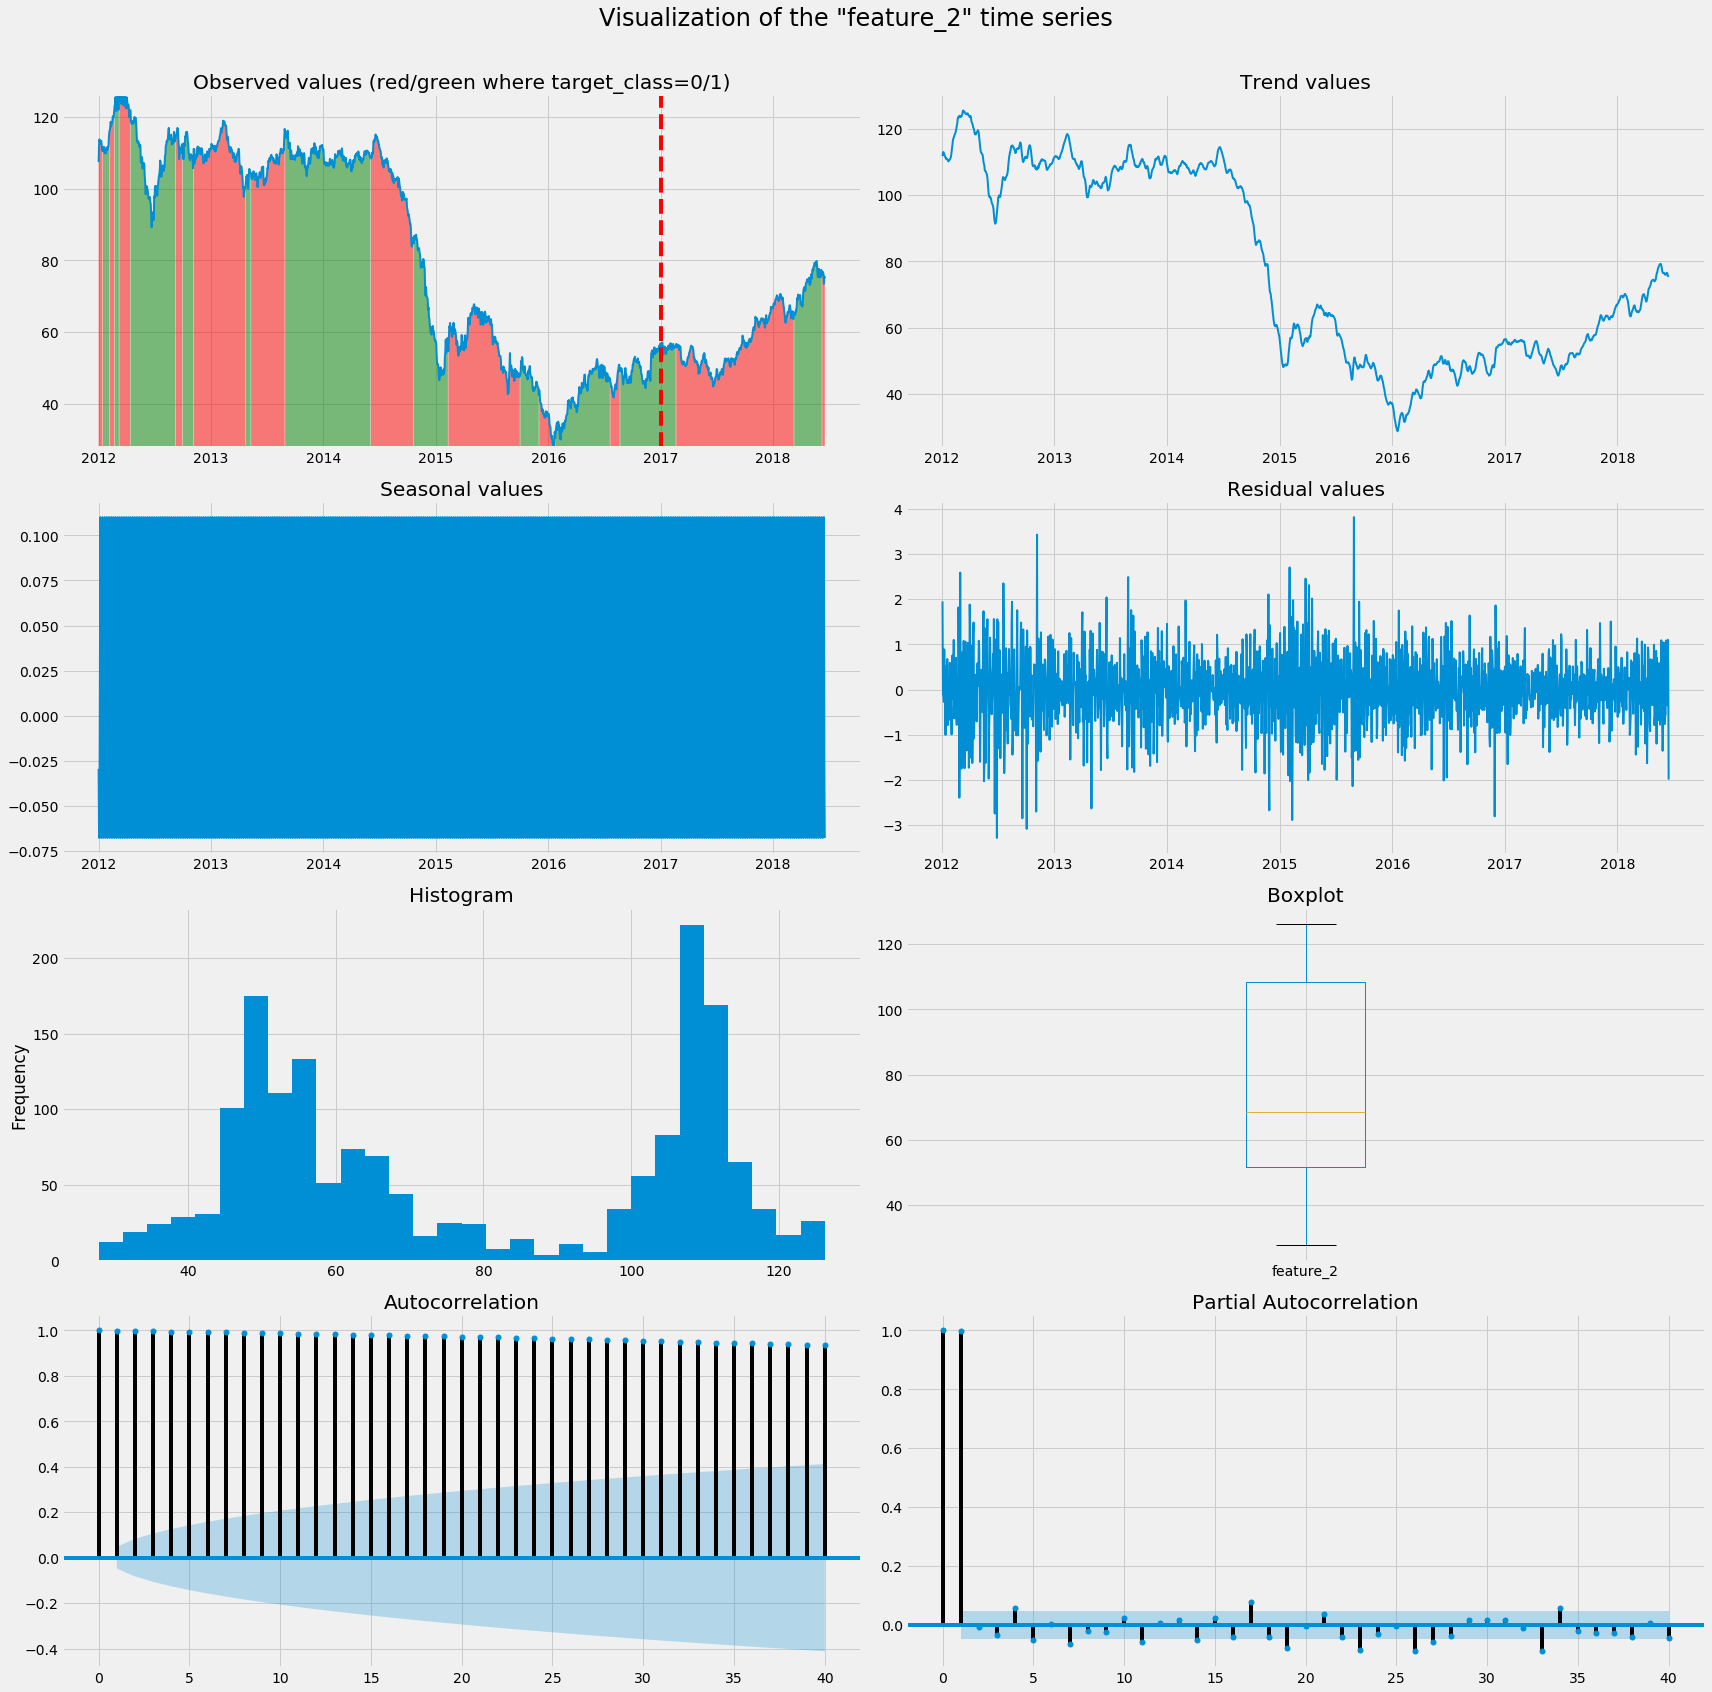

In [47]:
# Call EDA function to explore the time series
eda(df, 'feature_2')

# <a name="feature_3"></a> A-3. feature_3
[Back to INDEX](#index)

Statistic of feature_3 time series
count    1687.000000
mean      456.004718
std       136.225121
min       315.250000
25%       361.750000
50%       385.620000
75%       503.250000
max       830.380000
Name: feature_3, dtype: float64


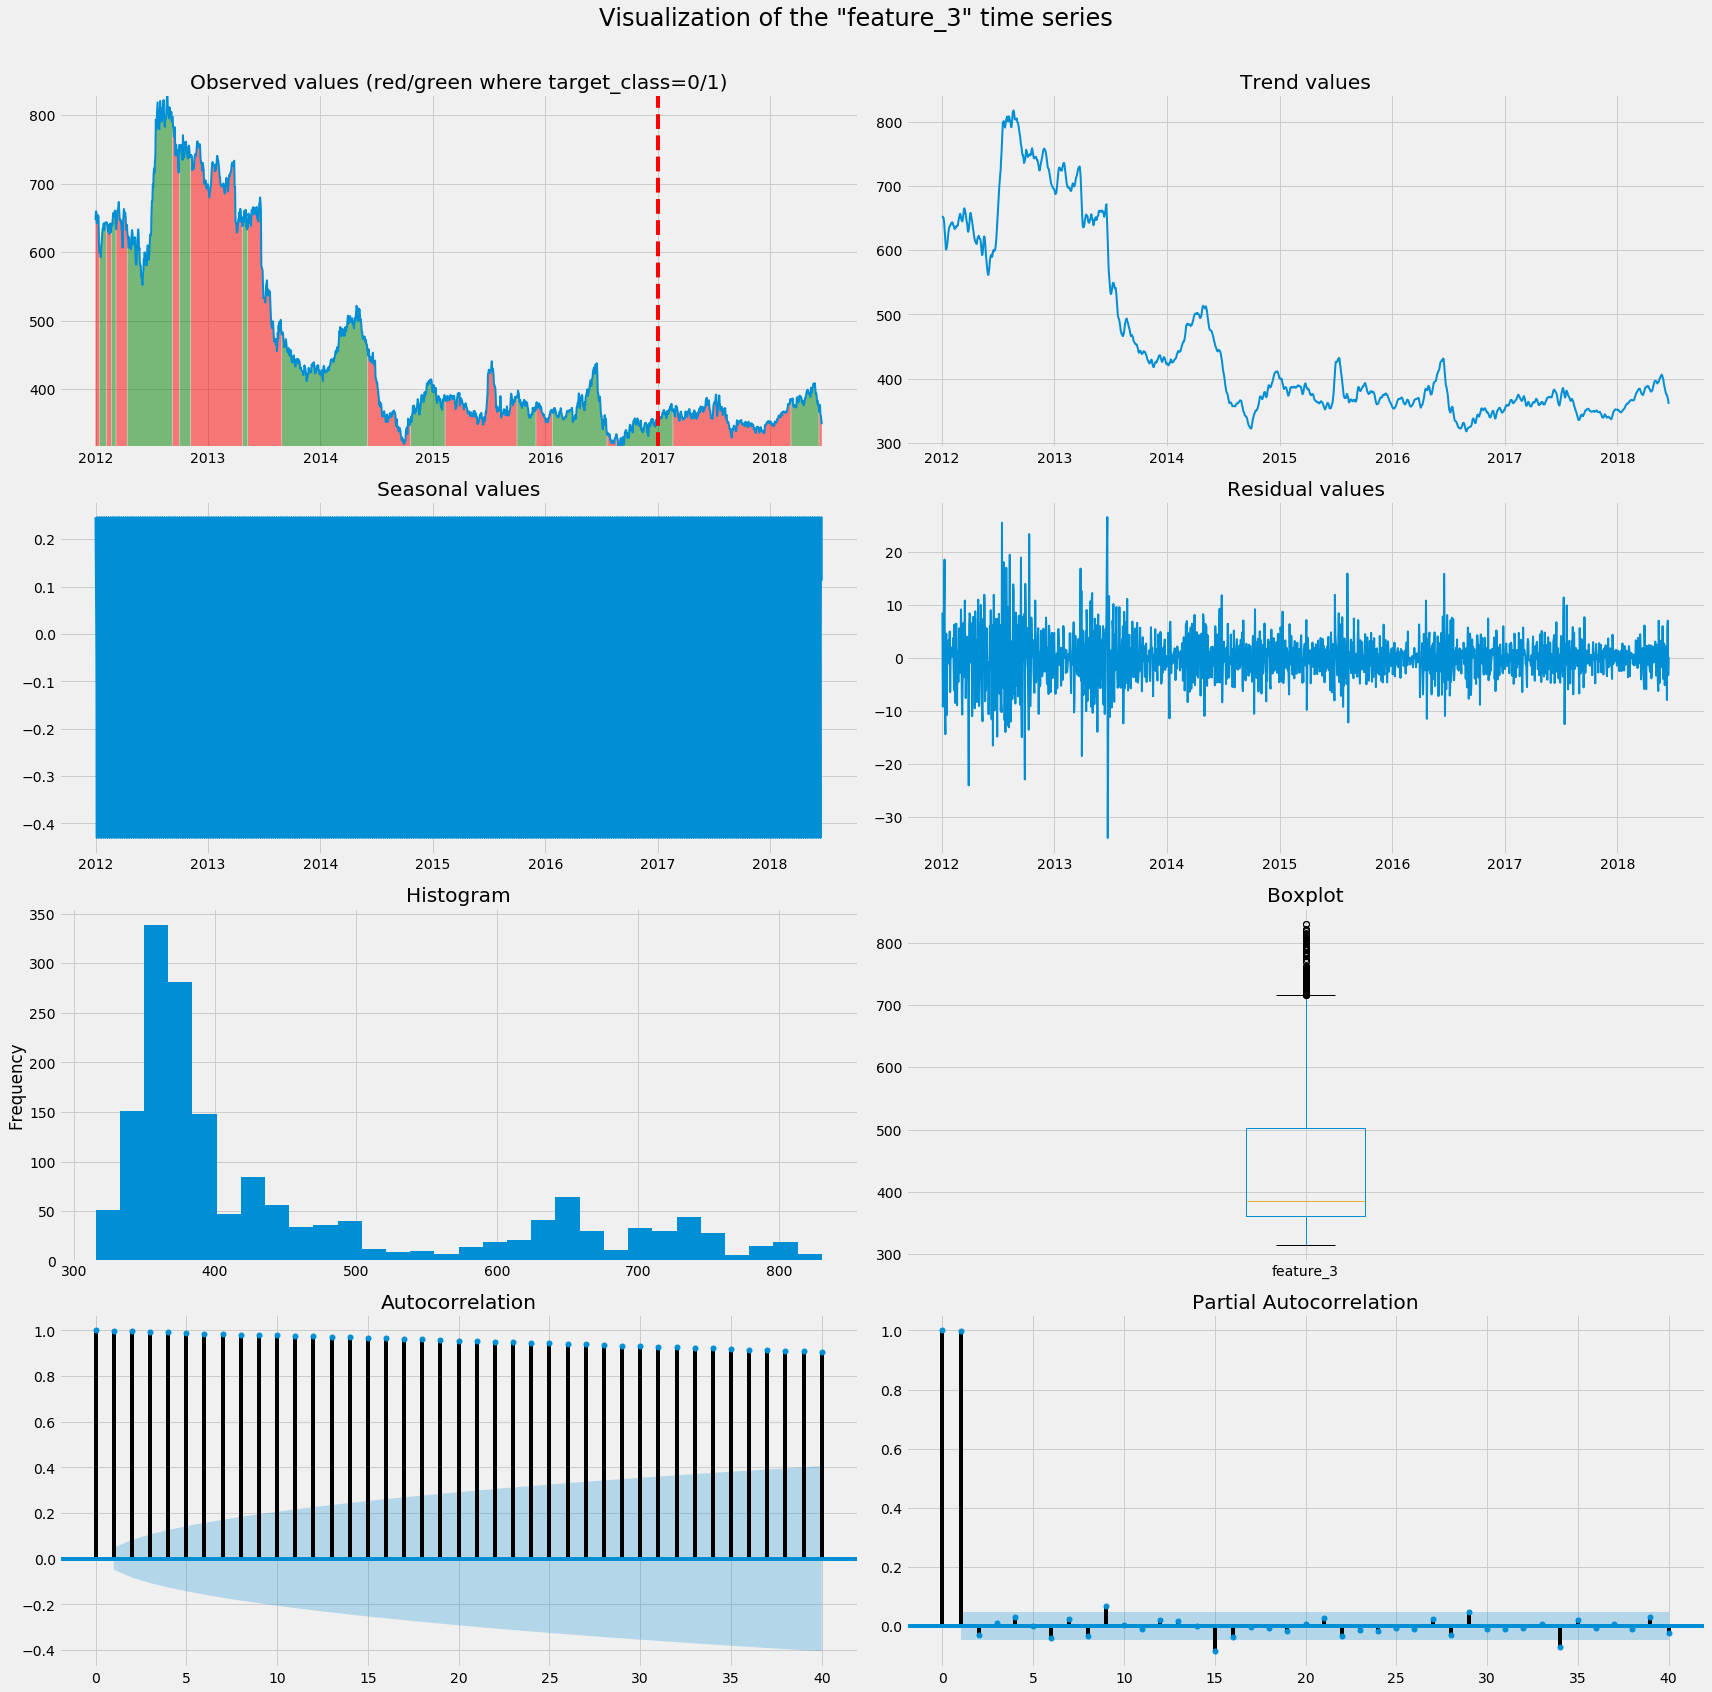

In [48]:
# Call EDA function to explore the time series
eda(df, 'feature_3')

# <a name="feature_4"></a> A-4. feature_4
[Back to INDEX](#index)

Statistic of feature_4 time series
count    1687.000000
mean        3.147134
std         0.725657
min         1.639000
25%         2.693000
50%         2.968000
75%         3.629000
max         6.149000
Name: feature_4, dtype: float64


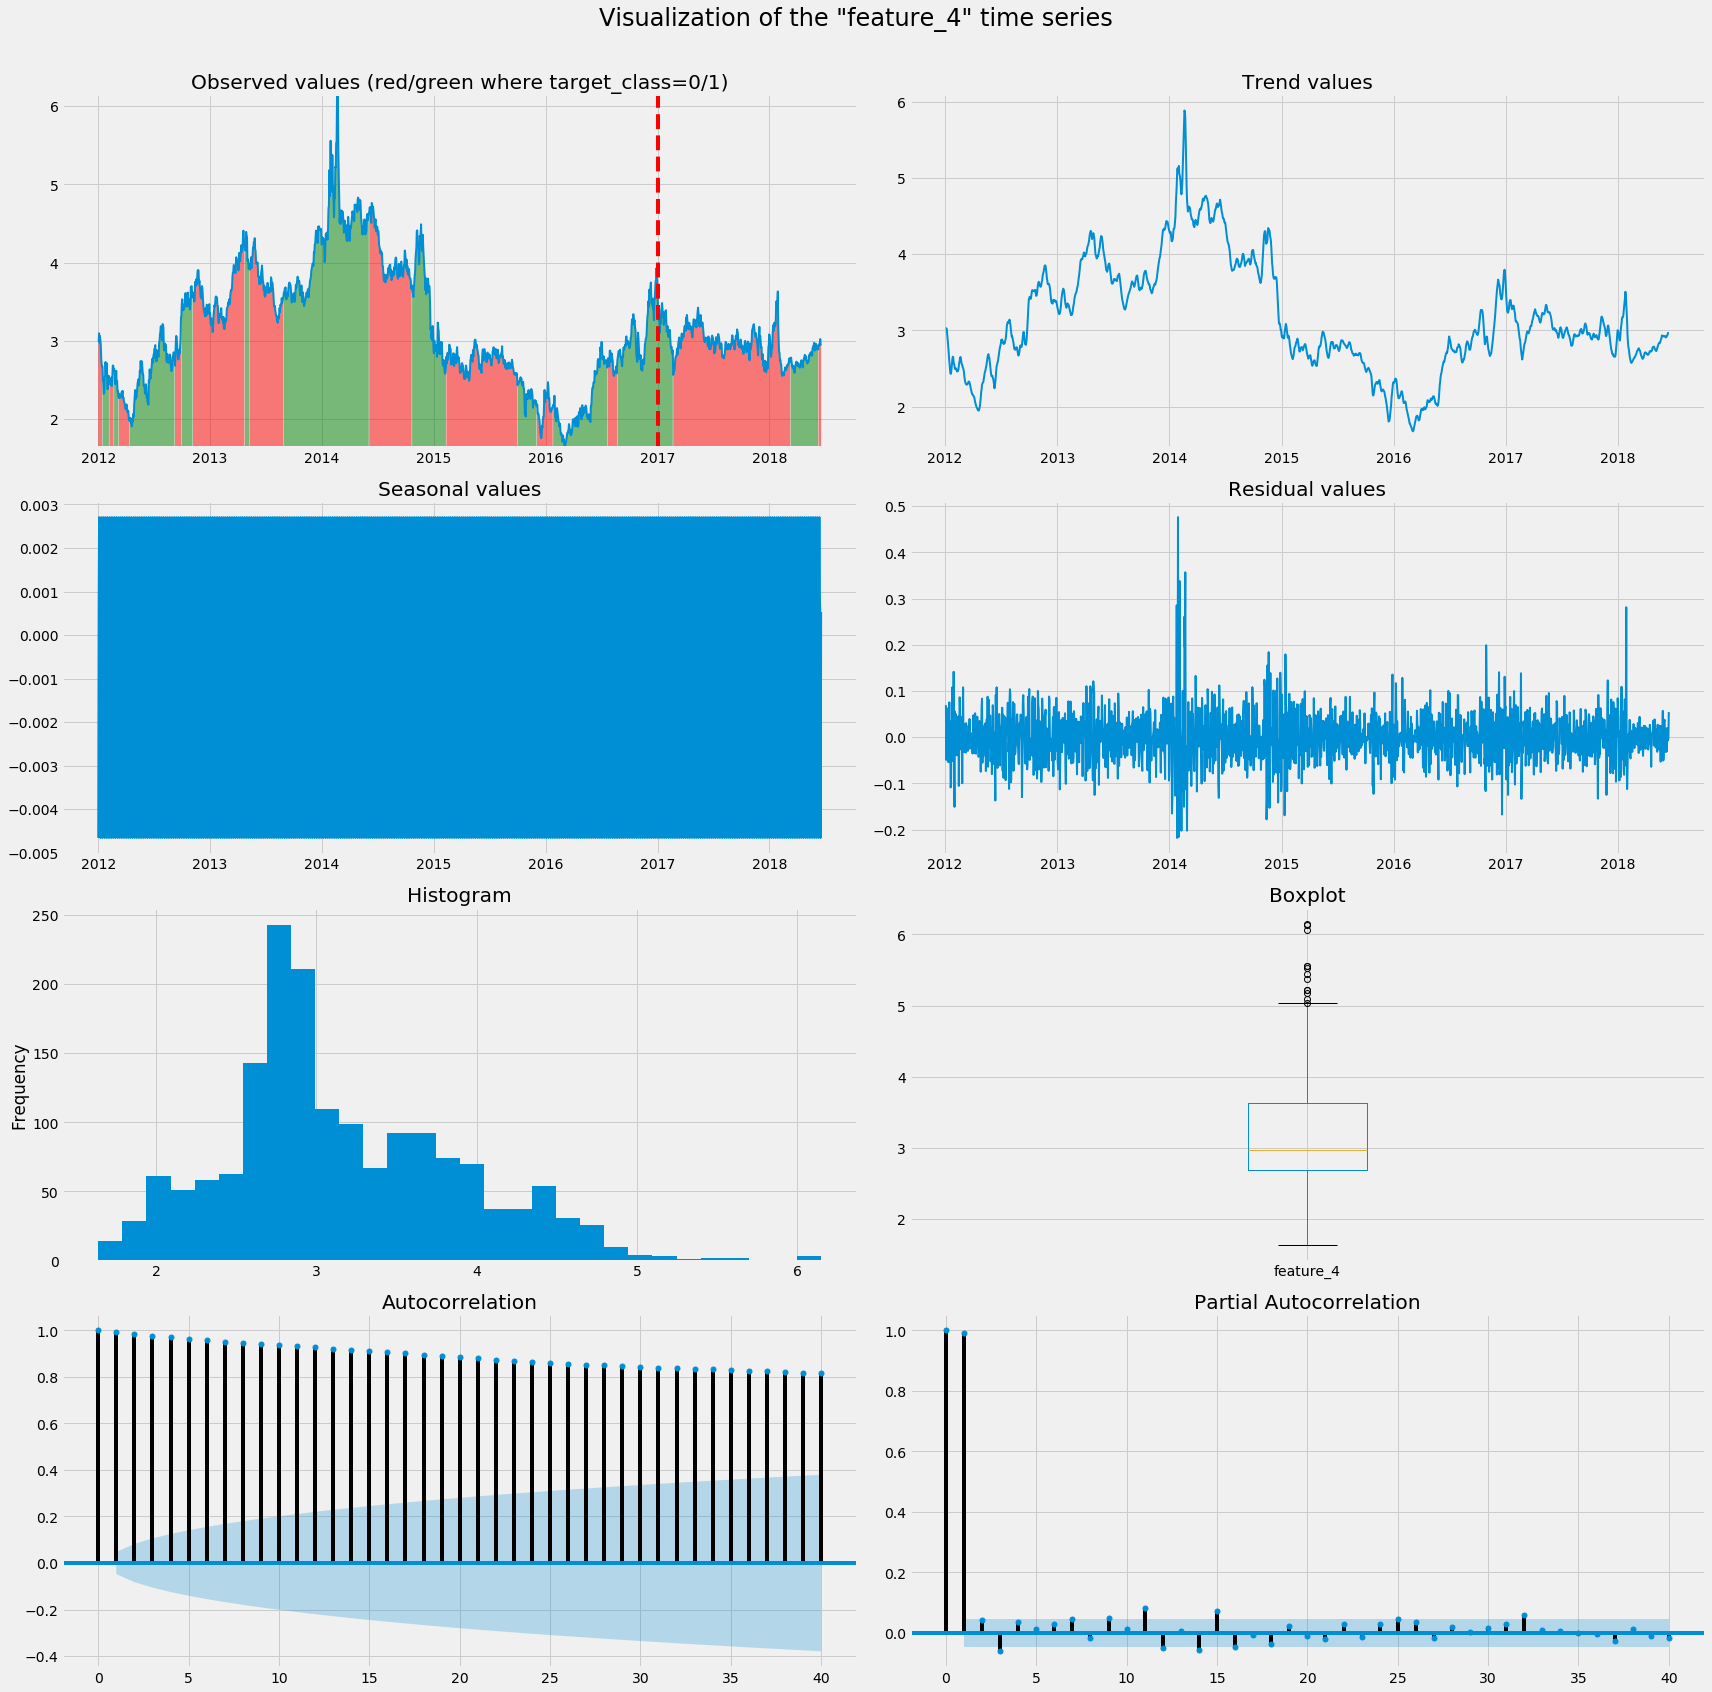

In [49]:
# Call EDA function to explore the time series
eda(df, 'feature_4')

# <a name="feature_5"></a> A-5. feature_5
[Back to INDEX](#index)

Statistic of feature_5 time series
count    1687.000000
mean      100.000000
std         0.000006
min        99.999980
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000020
Name: feature_5, dtype: float64


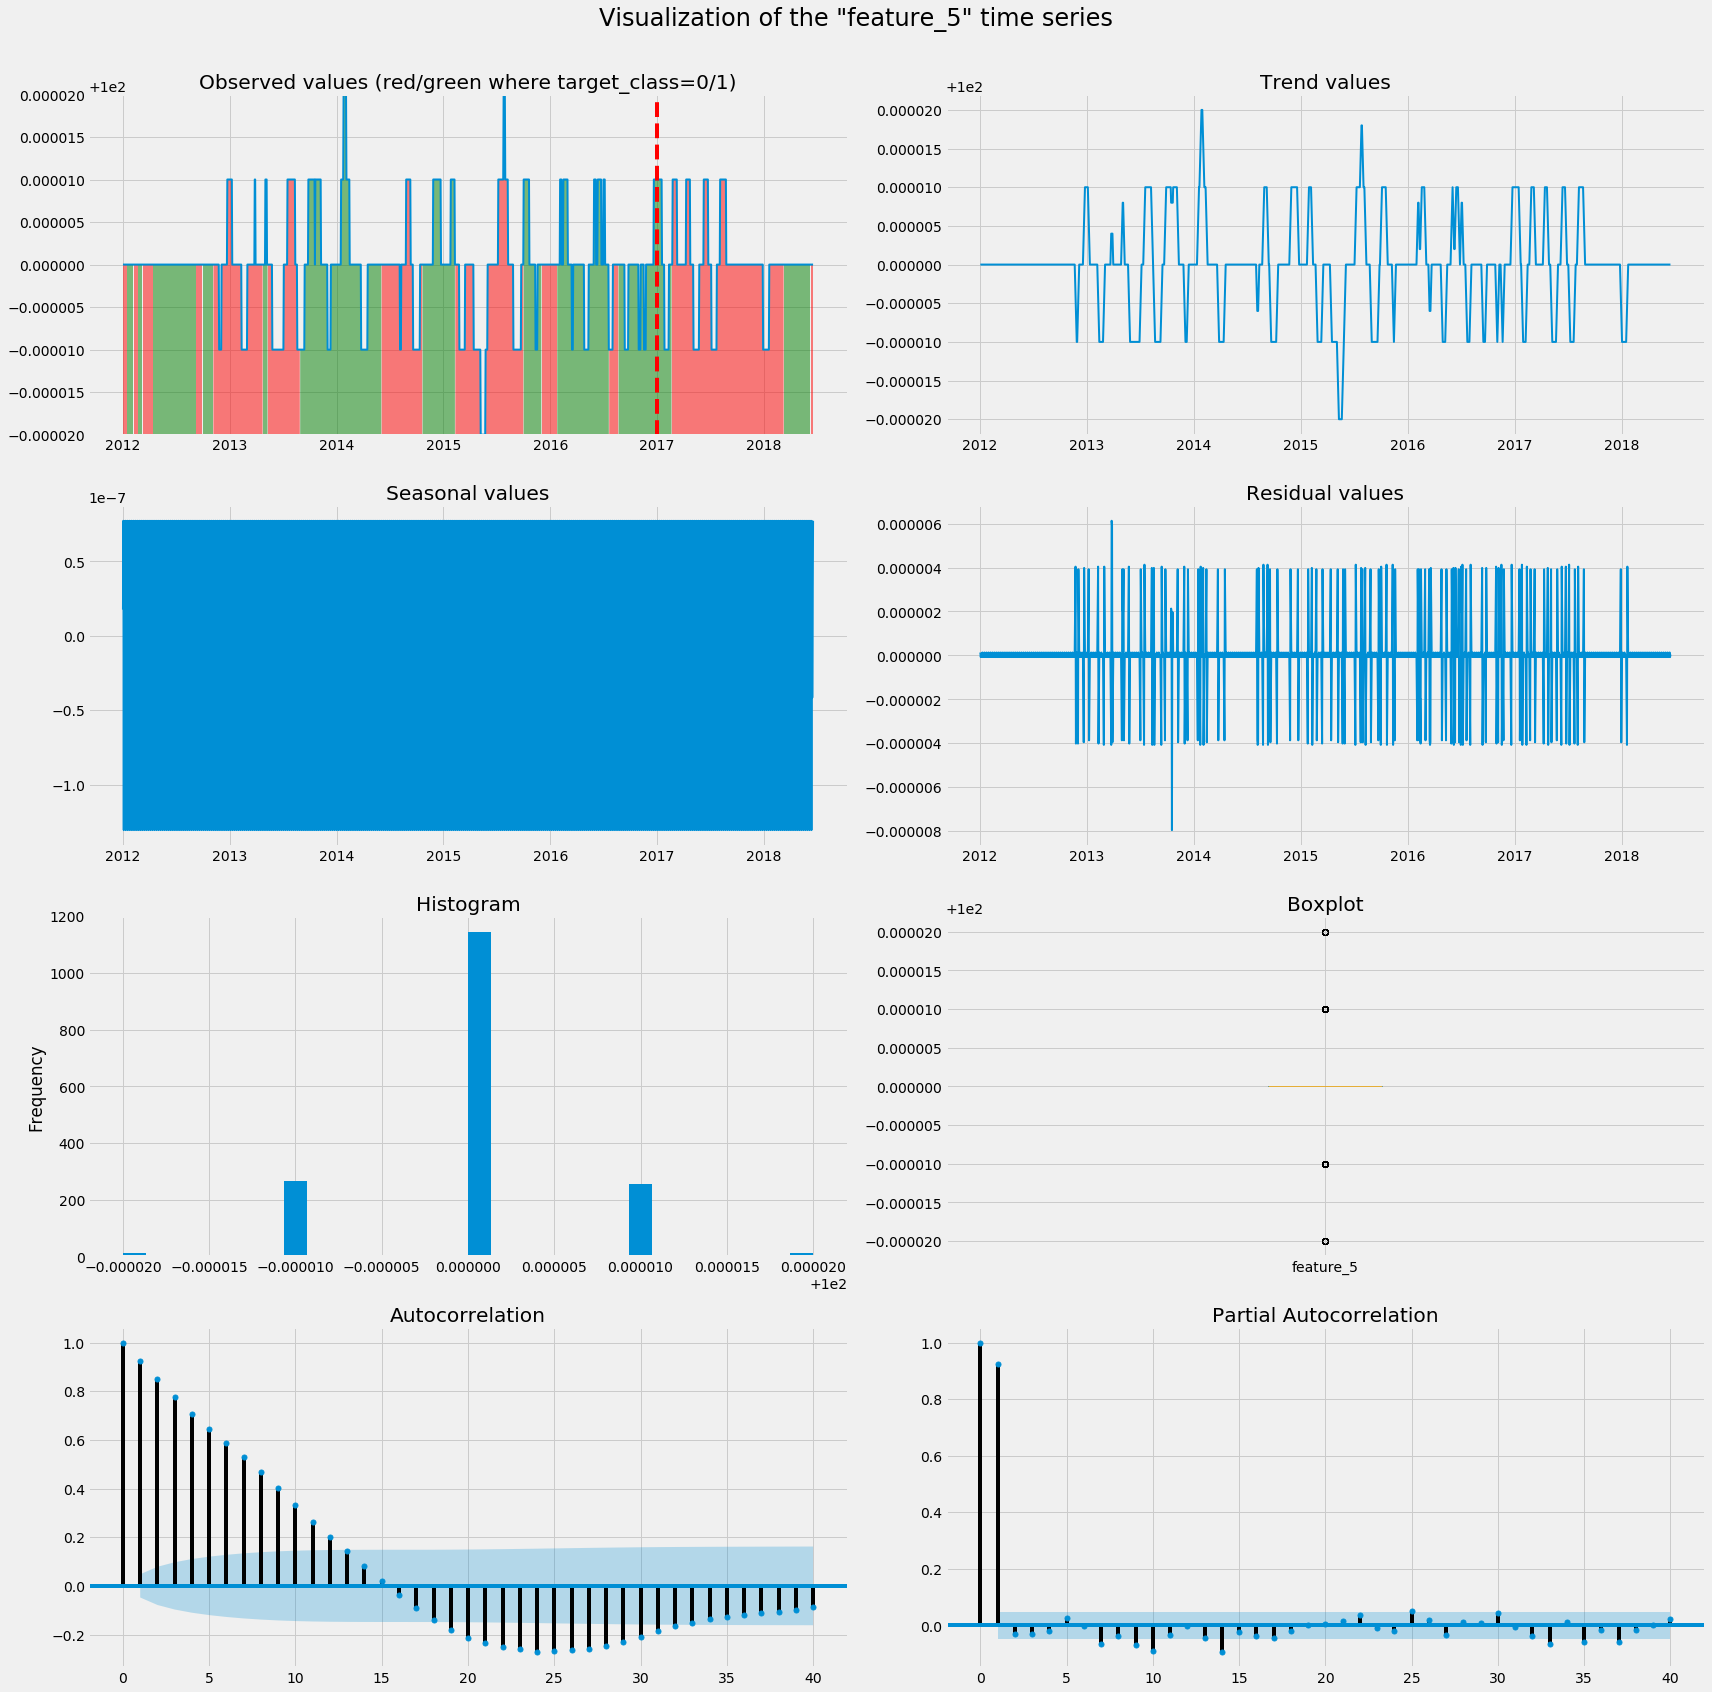

In [50]:
# Call EDA function to explore the time series
eda(df, 'feature_5')

# <a name="feature_6"></a> A-6. feature_6
[Back to INDEX](#index)

Statistic of feature_6 time series
count    1687.000000
mean      100.001655
std         0.017130
min        99.958600
25%        99.988535
50%       100.003080
75%       100.014050
max       100.045650
Name: feature_6, dtype: float64


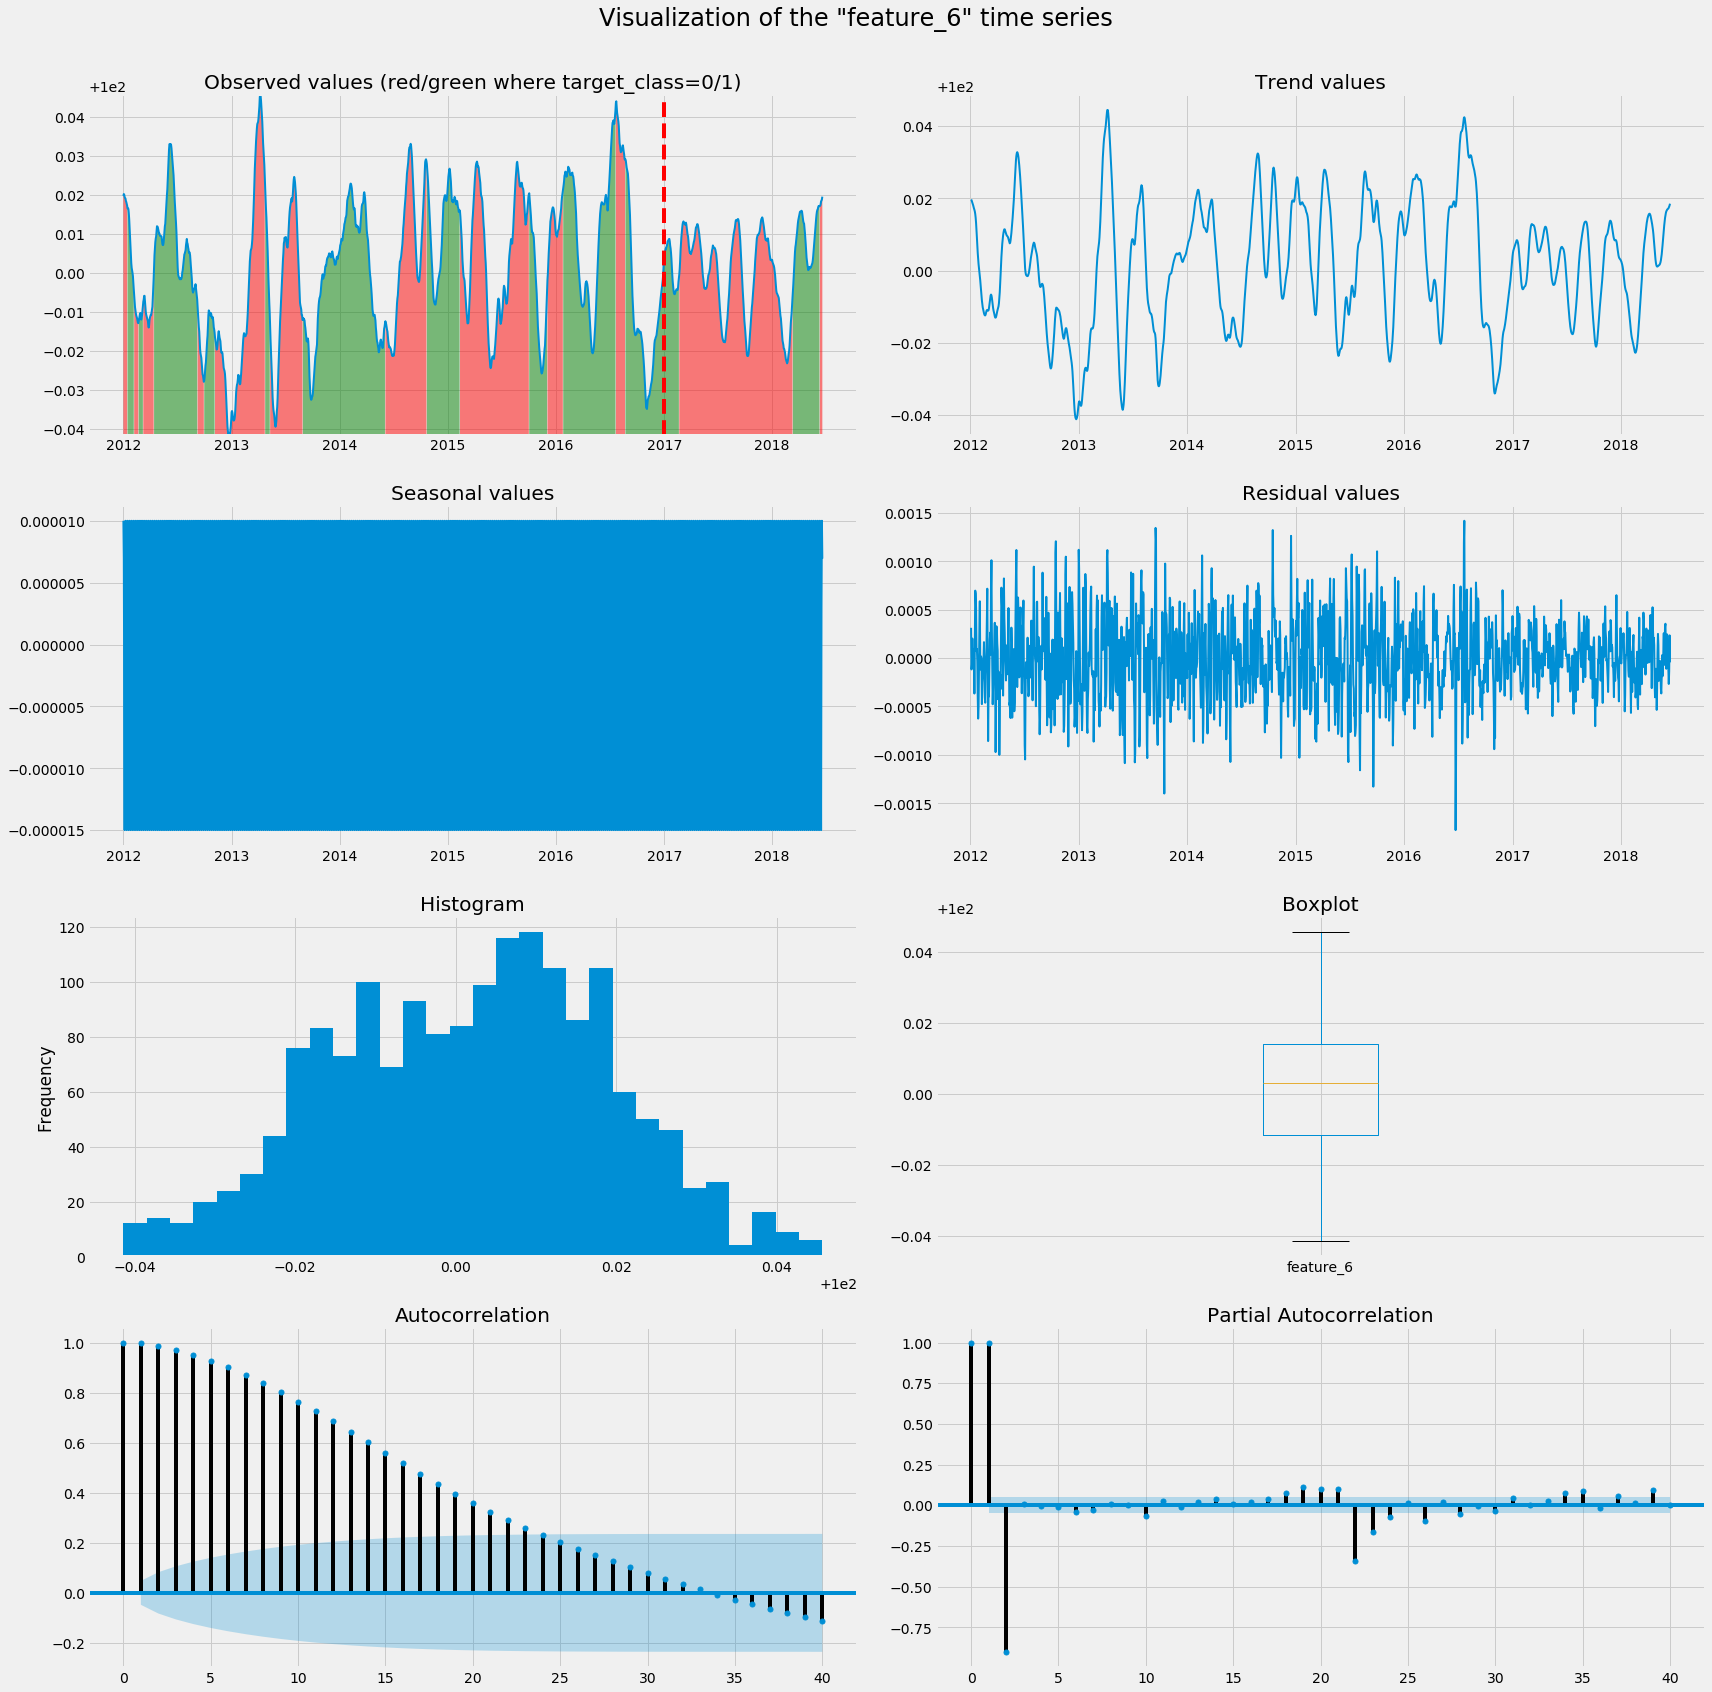

In [51]:
# Call EDA function to explore the time series
eda(df, 'feature_6')

# <a name="feature_7"></a> A-7. feature_7
[Back to INDEX](#index)

Statistic of feature_7 time series
count    1687.000000
mean       99.999139
std         0.010913
min        99.975260
25%        99.992460
50%        99.997900
75%       100.002790
max       100.040210
Name: feature_7, dtype: float64


/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


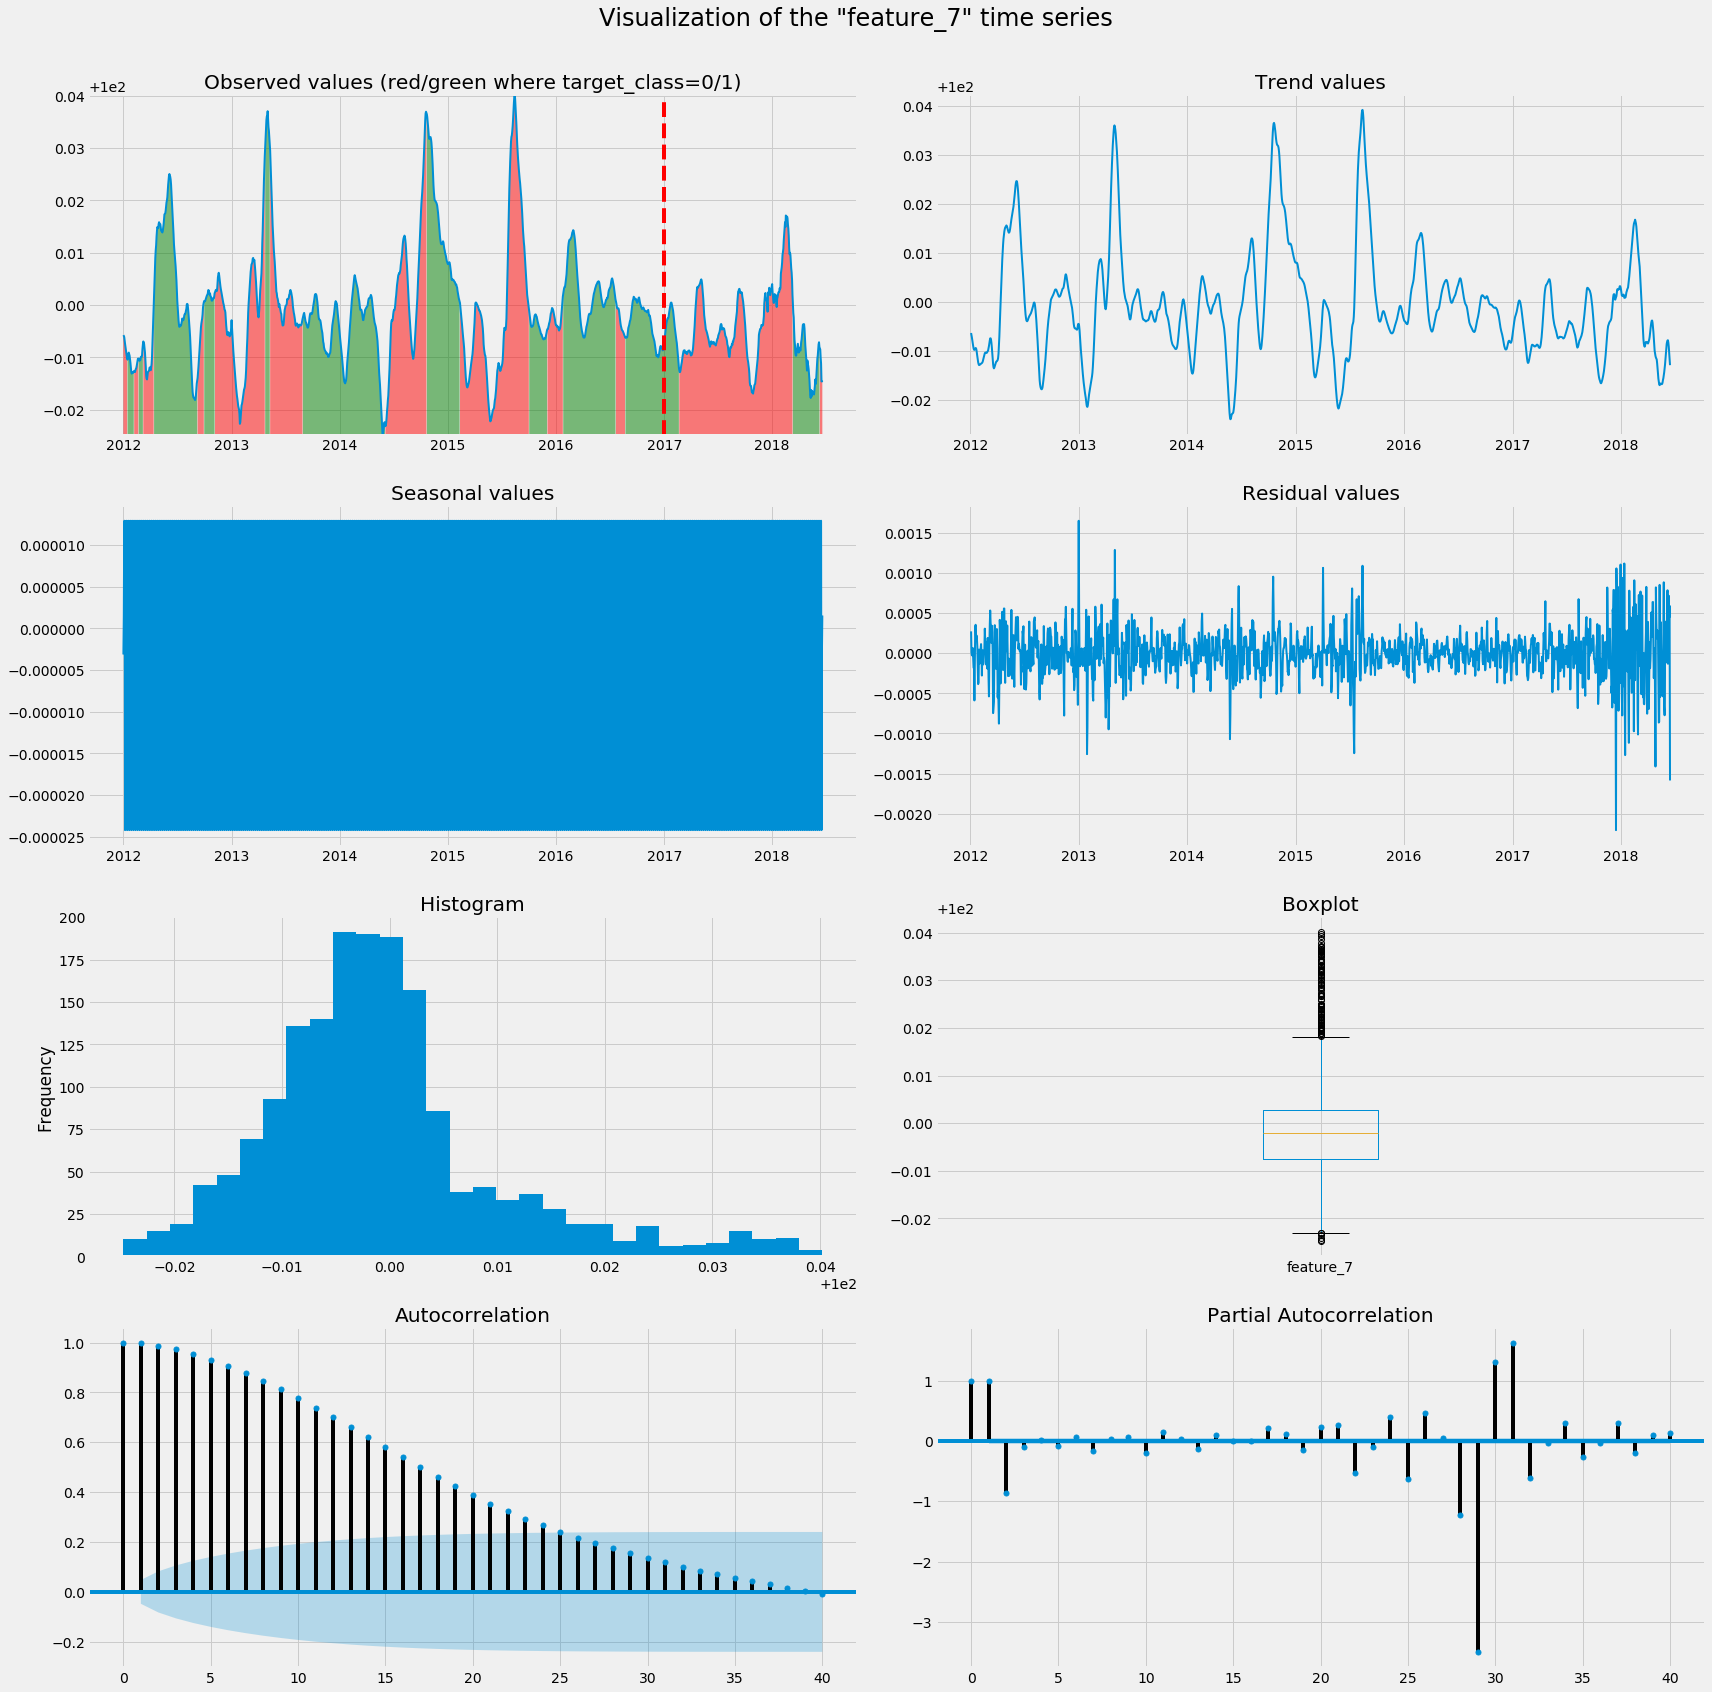

In [52]:
# Call EDA function to explore the time series
eda(df, 'feature_7')

# <a name="feature_8"></a> A-8. feature_8
[Back to INDEX](#index)

Statistic of feature_8 time series
count    1687.000000
mean      106.376068
std        77.335033
min      -340.341959
25%        99.837080
50%       100.010800
75%       100.212422
max       780.009937
Name: feature_8, dtype: float64


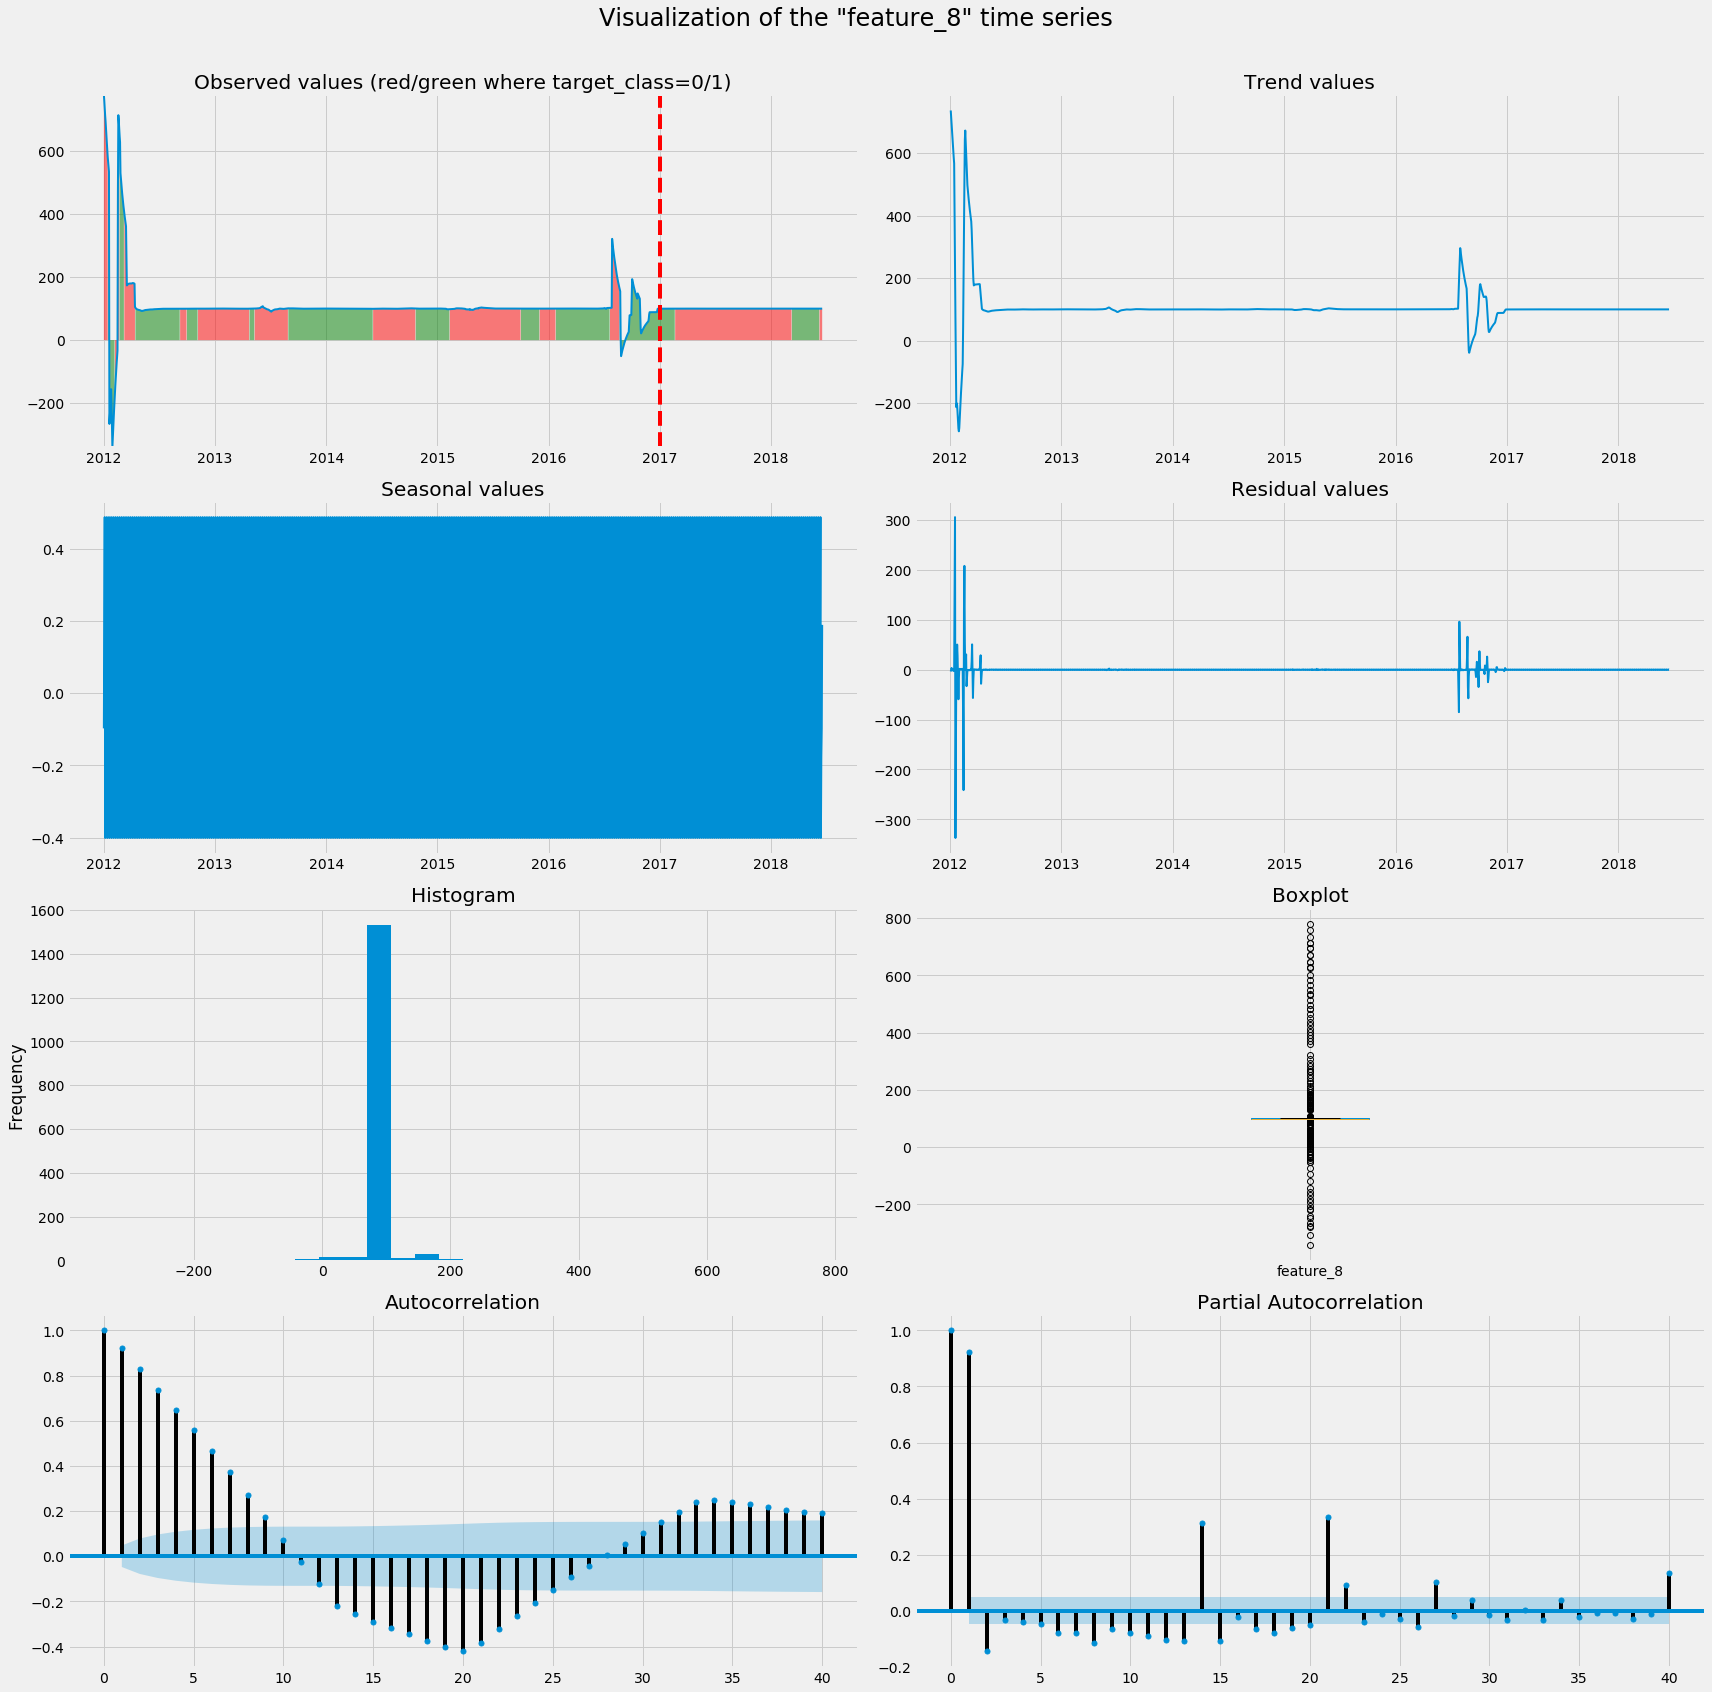

In [53]:
# Call EDA function to explore the time series
eda(df, 'feature_8')

# <a name="feature_9"></a> A-9. feature_9
[Back to INDEX](#index)

Statistic of feature_9 time series
count    1687.000000
mean      118.186766
std       416.394281
min     -3413.280000
25%        98.670705
50%       100.065050
75%       101.033350
max      2626.440000
Name: feature_9, dtype: float64


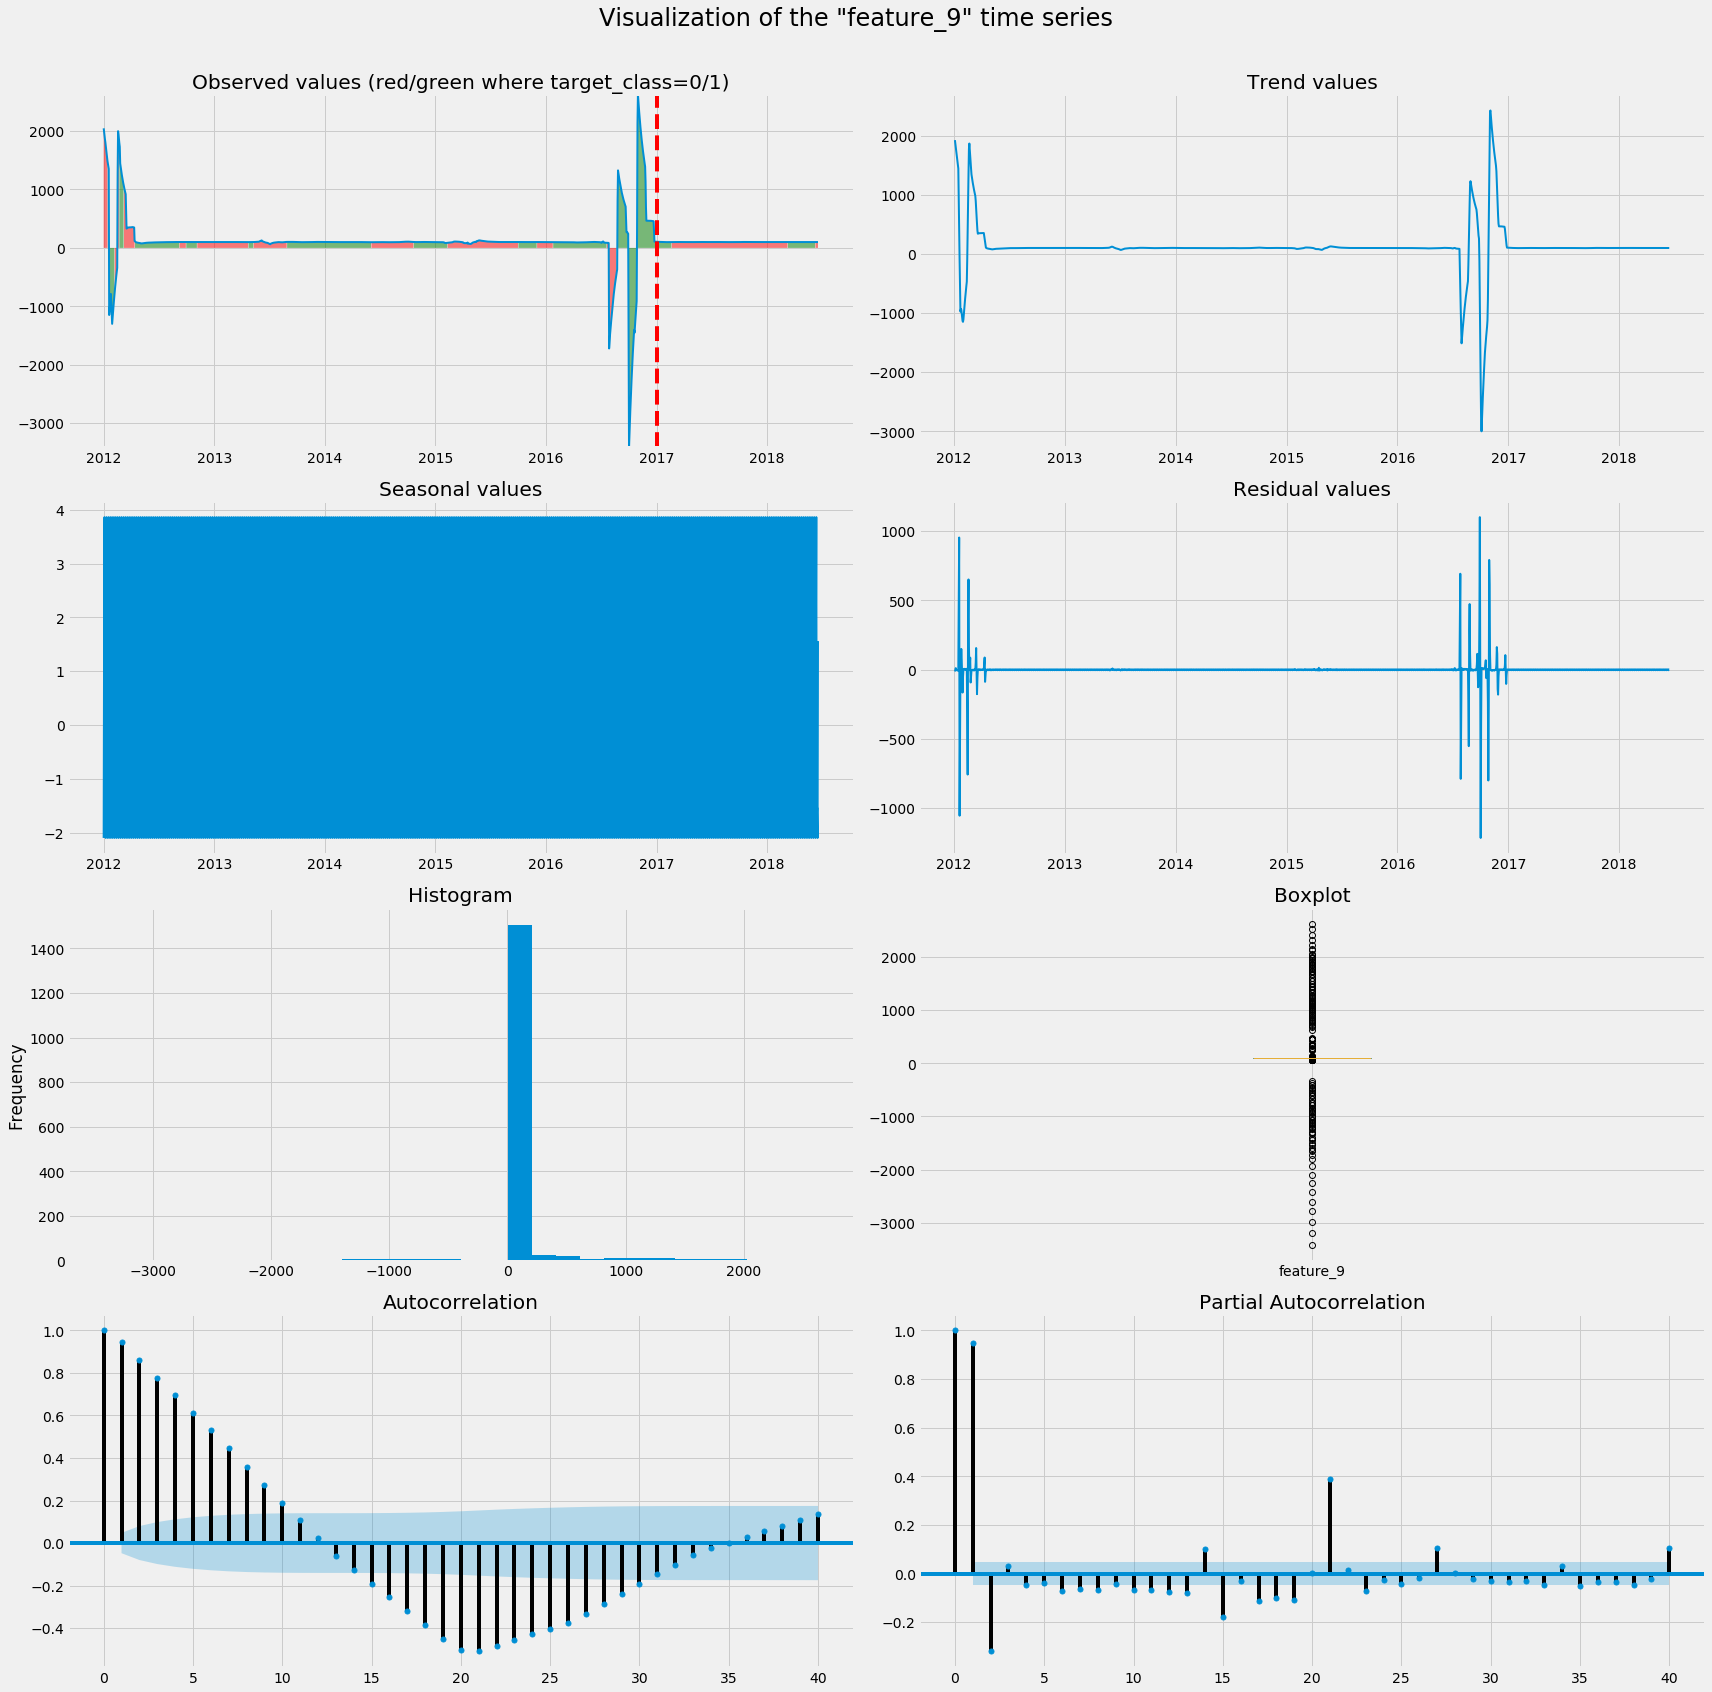

In [54]:
# Call EDA function to explore the time series
eda(df, 'feature_9')

# <a name="feature_10"></a> A-10. feature_10
[Back to INDEX](#index)

Statistic of feature_10 time series
count    1687.000000
mean      119.725374
std       324.174677
min     -2104.320000
25%        98.825686
50%       100.067772
75%       100.879678
max      2206.400000
Name: feature_10, dtype: float64


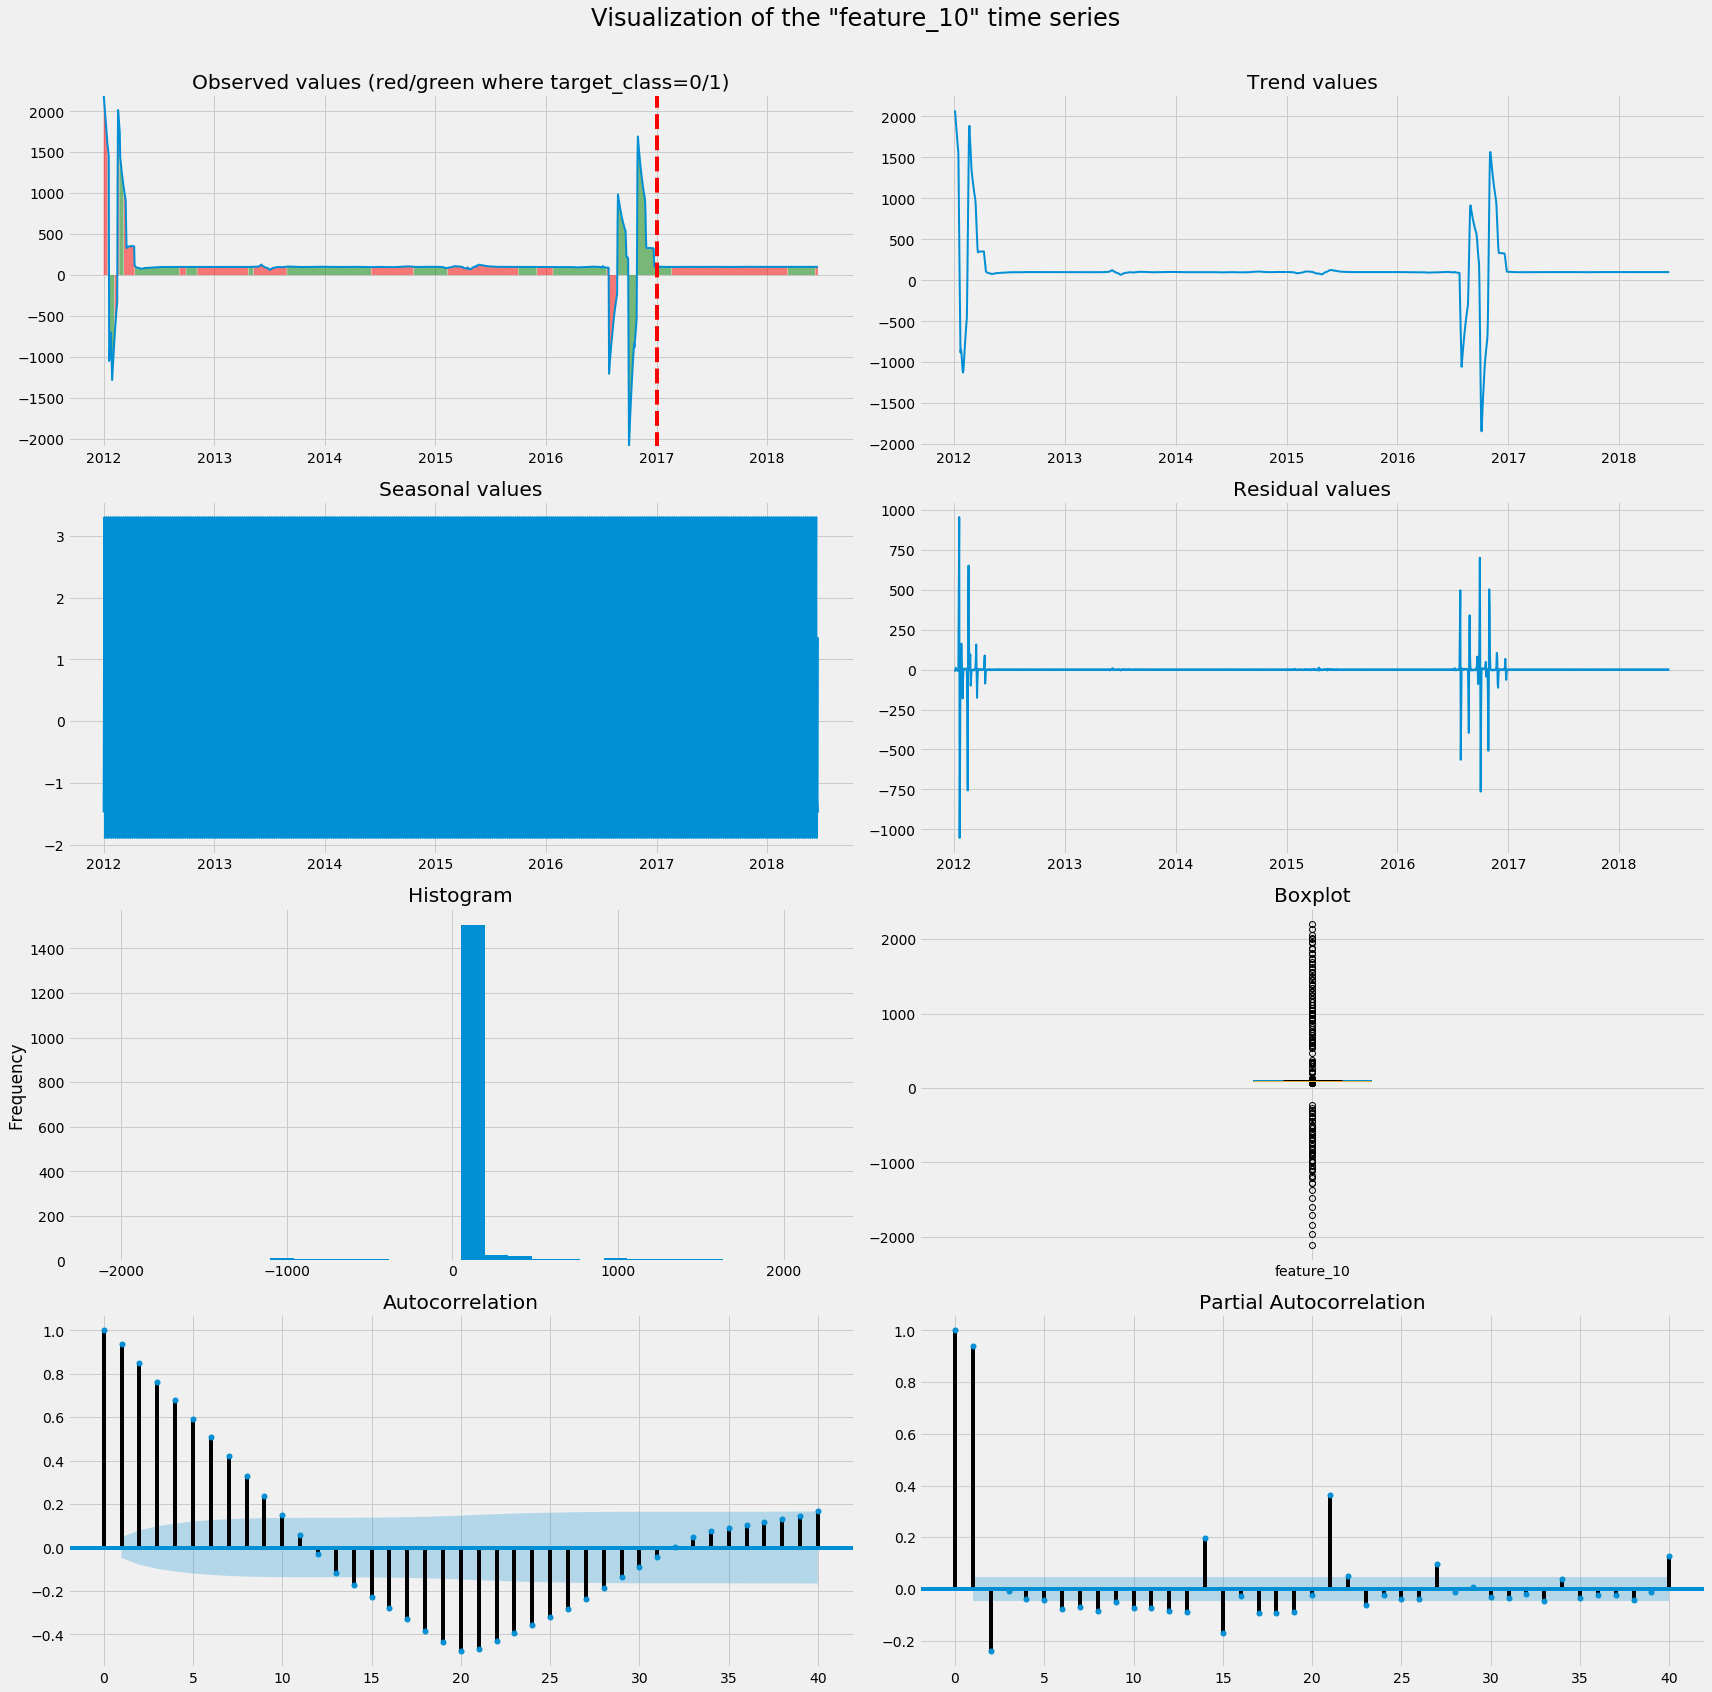

In [55]:
# Call EDA function to explore the time series
eda(df, 'feature_10')

# <a name="feature_11"></a> A-11. feature_11
[Back to INDEX](#index)

Statistic of feature_11 time series
count    1687.000000
mean      100.003464
std       154.915843
min     -1321.160000
25%        99.992350
50%       100.006112
75%       100.016624
max      1213.240000
Name: feature_11, dtype: float64


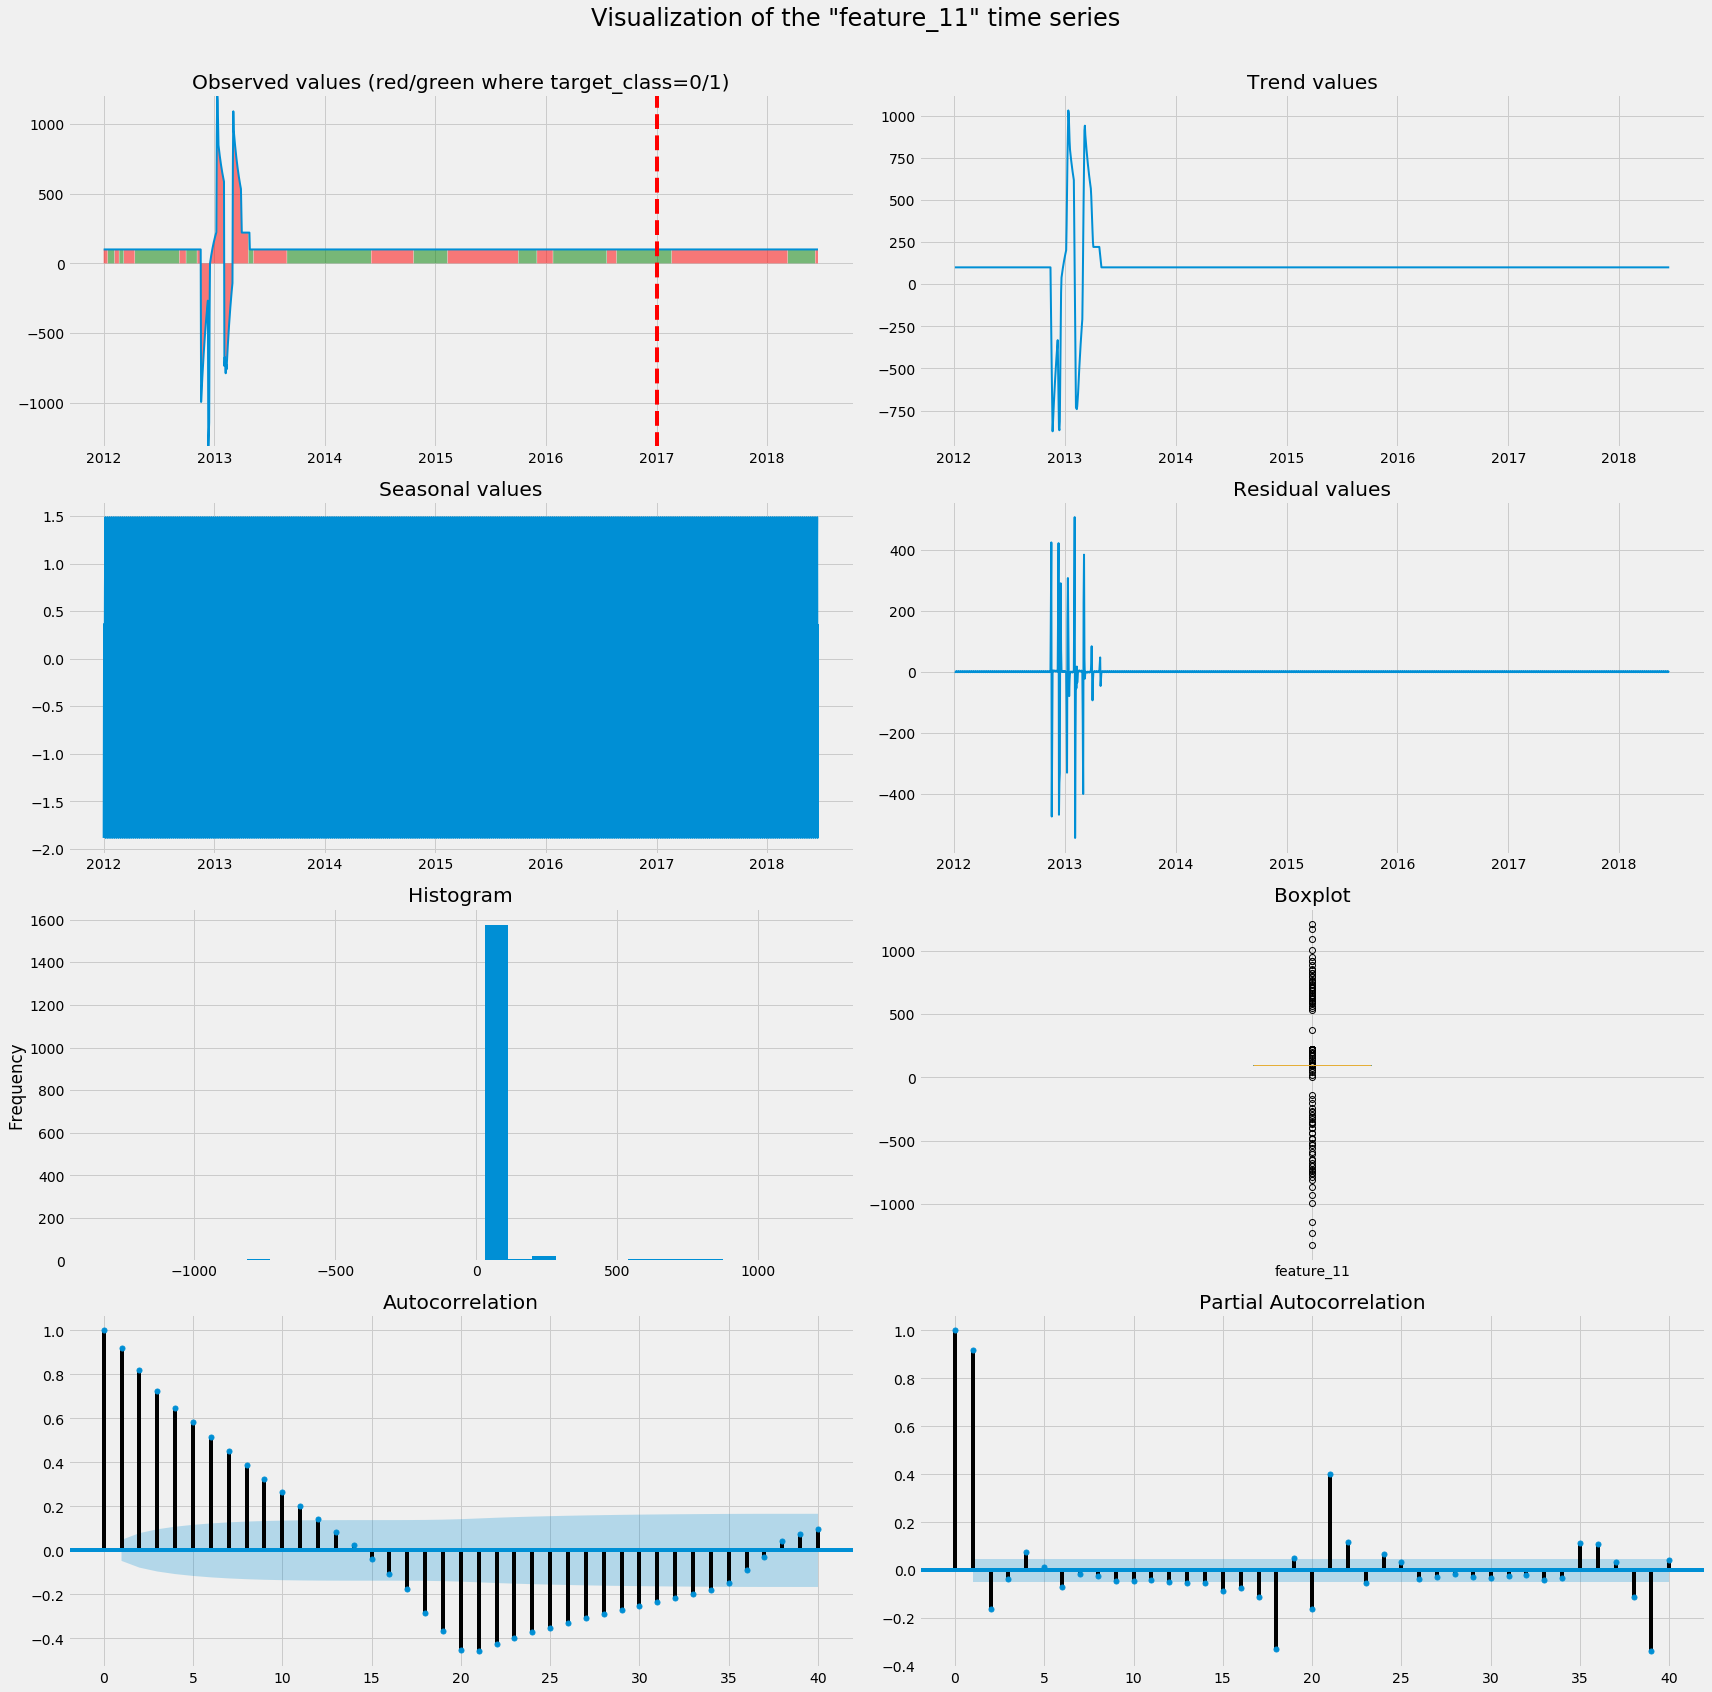

In [56]:
# Call EDA function to explore the time series
eda(df, 'feature_11')

# <a name="feature_12"></a> A-12. feature_12
[Back to INDEX](#index)

Statistic of feature_12 time series
count    1687.000000
mean      100.000858
std       314.711890
min     -2933.570000
25%        99.988280
50%       100.001230
75%       100.017190
max      2462.330000
Name: feature_12, dtype: float64


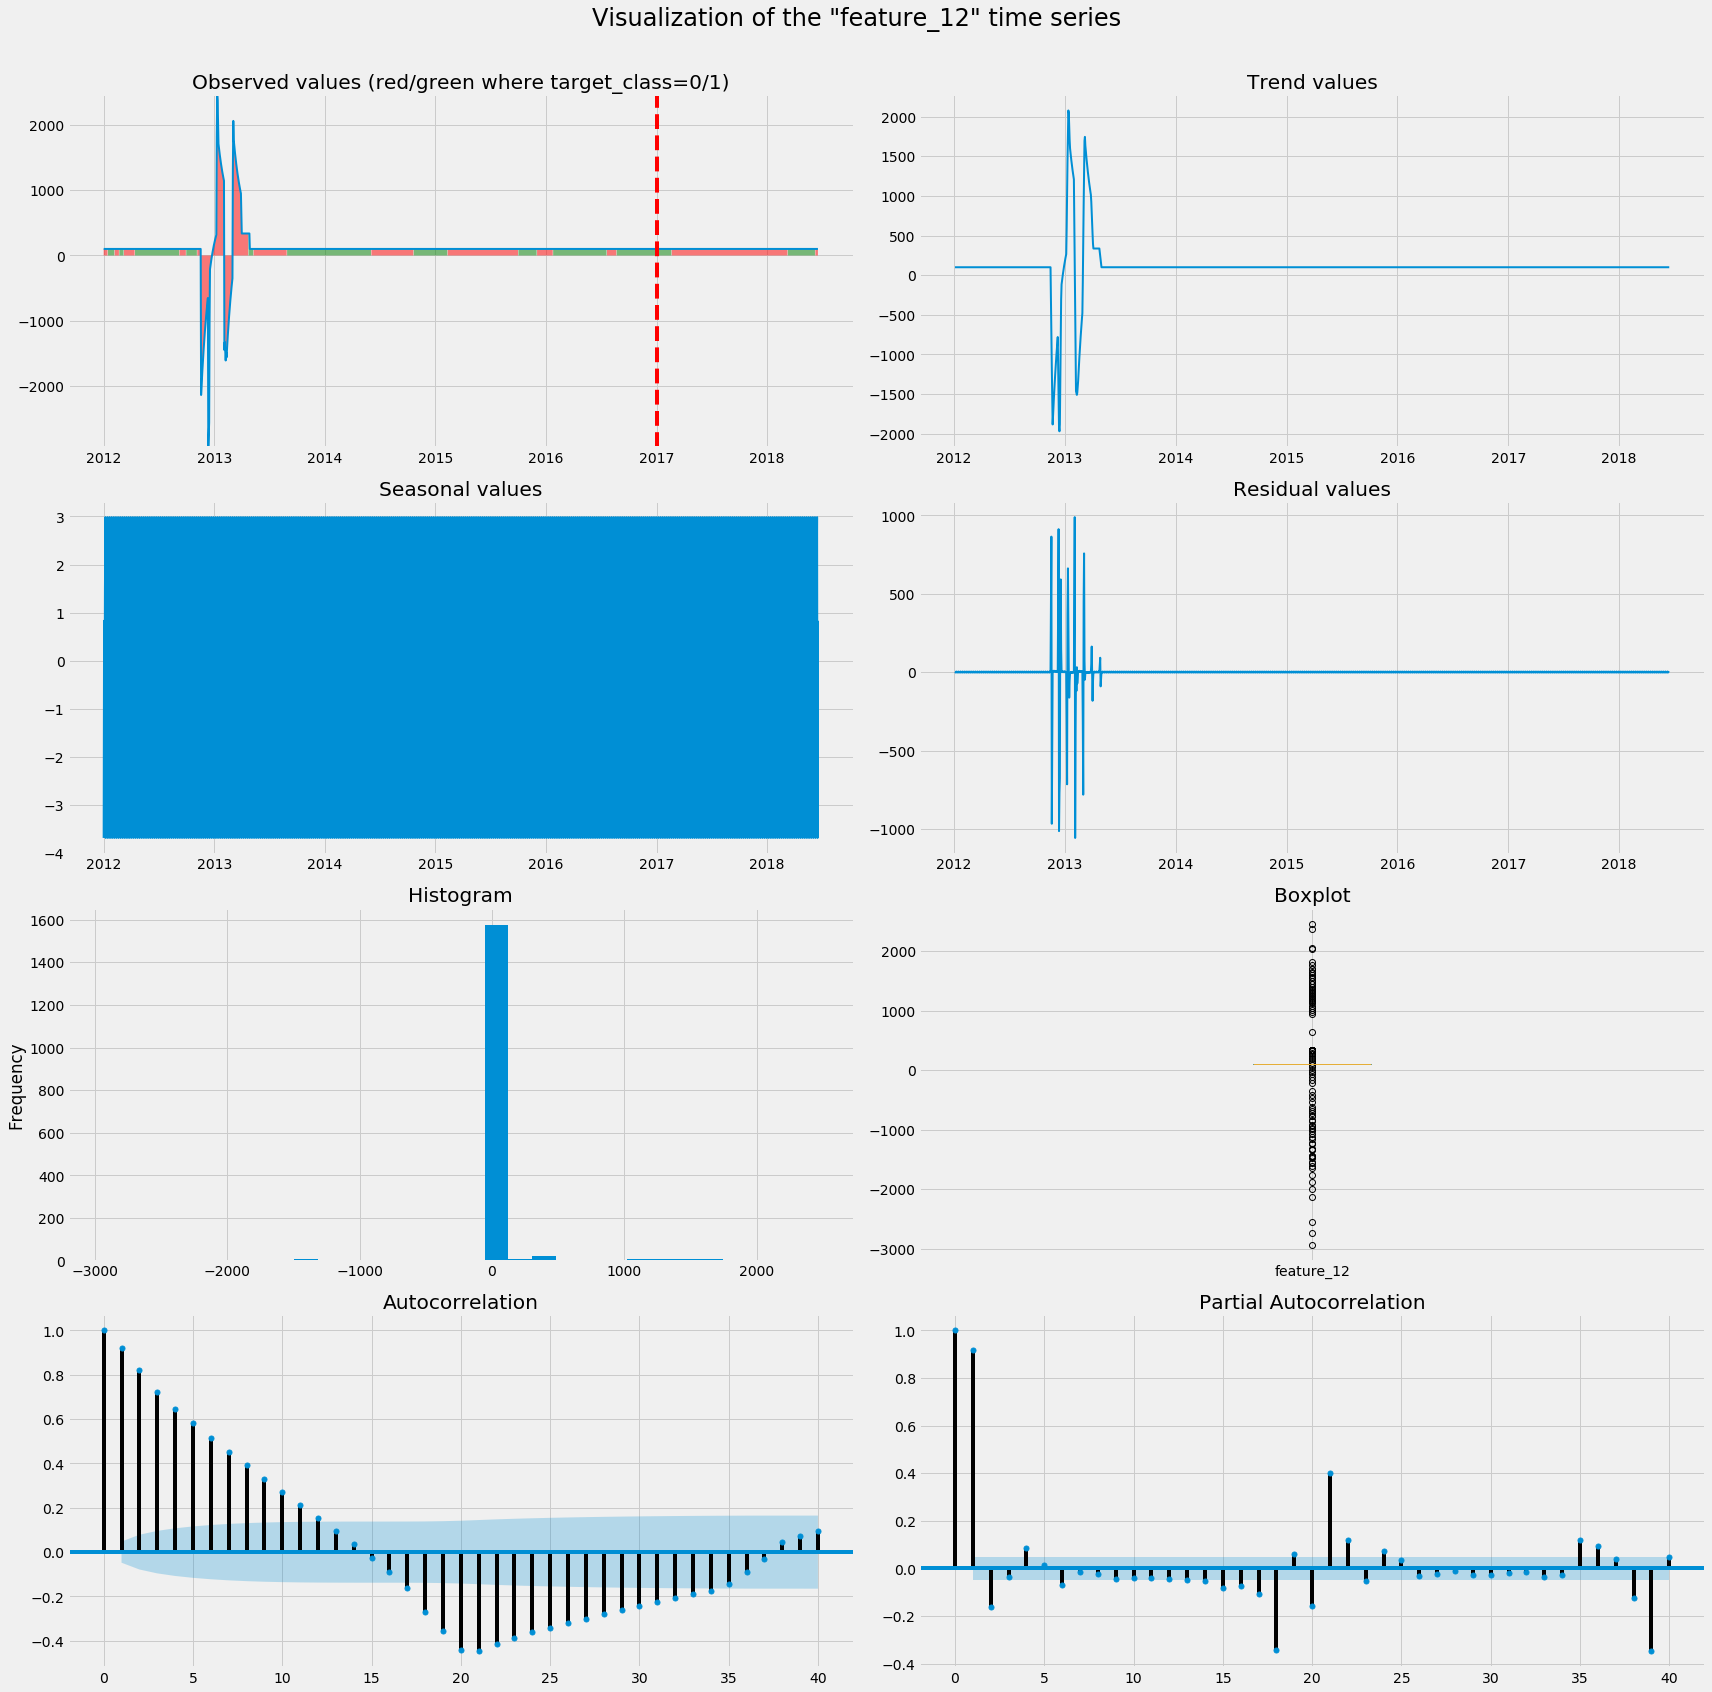

In [57]:
# Call EDA function to explore the time series
eda(df, 'feature_12')

# <a name="feature_13"></a> A-13. feature_13
[Back to INDEX](#index)

Statistic of feature_13 time series
count    1687.000000
mean      100.003531
std       338.136106
min     -3206.010000
25%        99.989090
50%       100.005710
75%       100.019640
max      2678.710000
Name: feature_13, dtype: float64


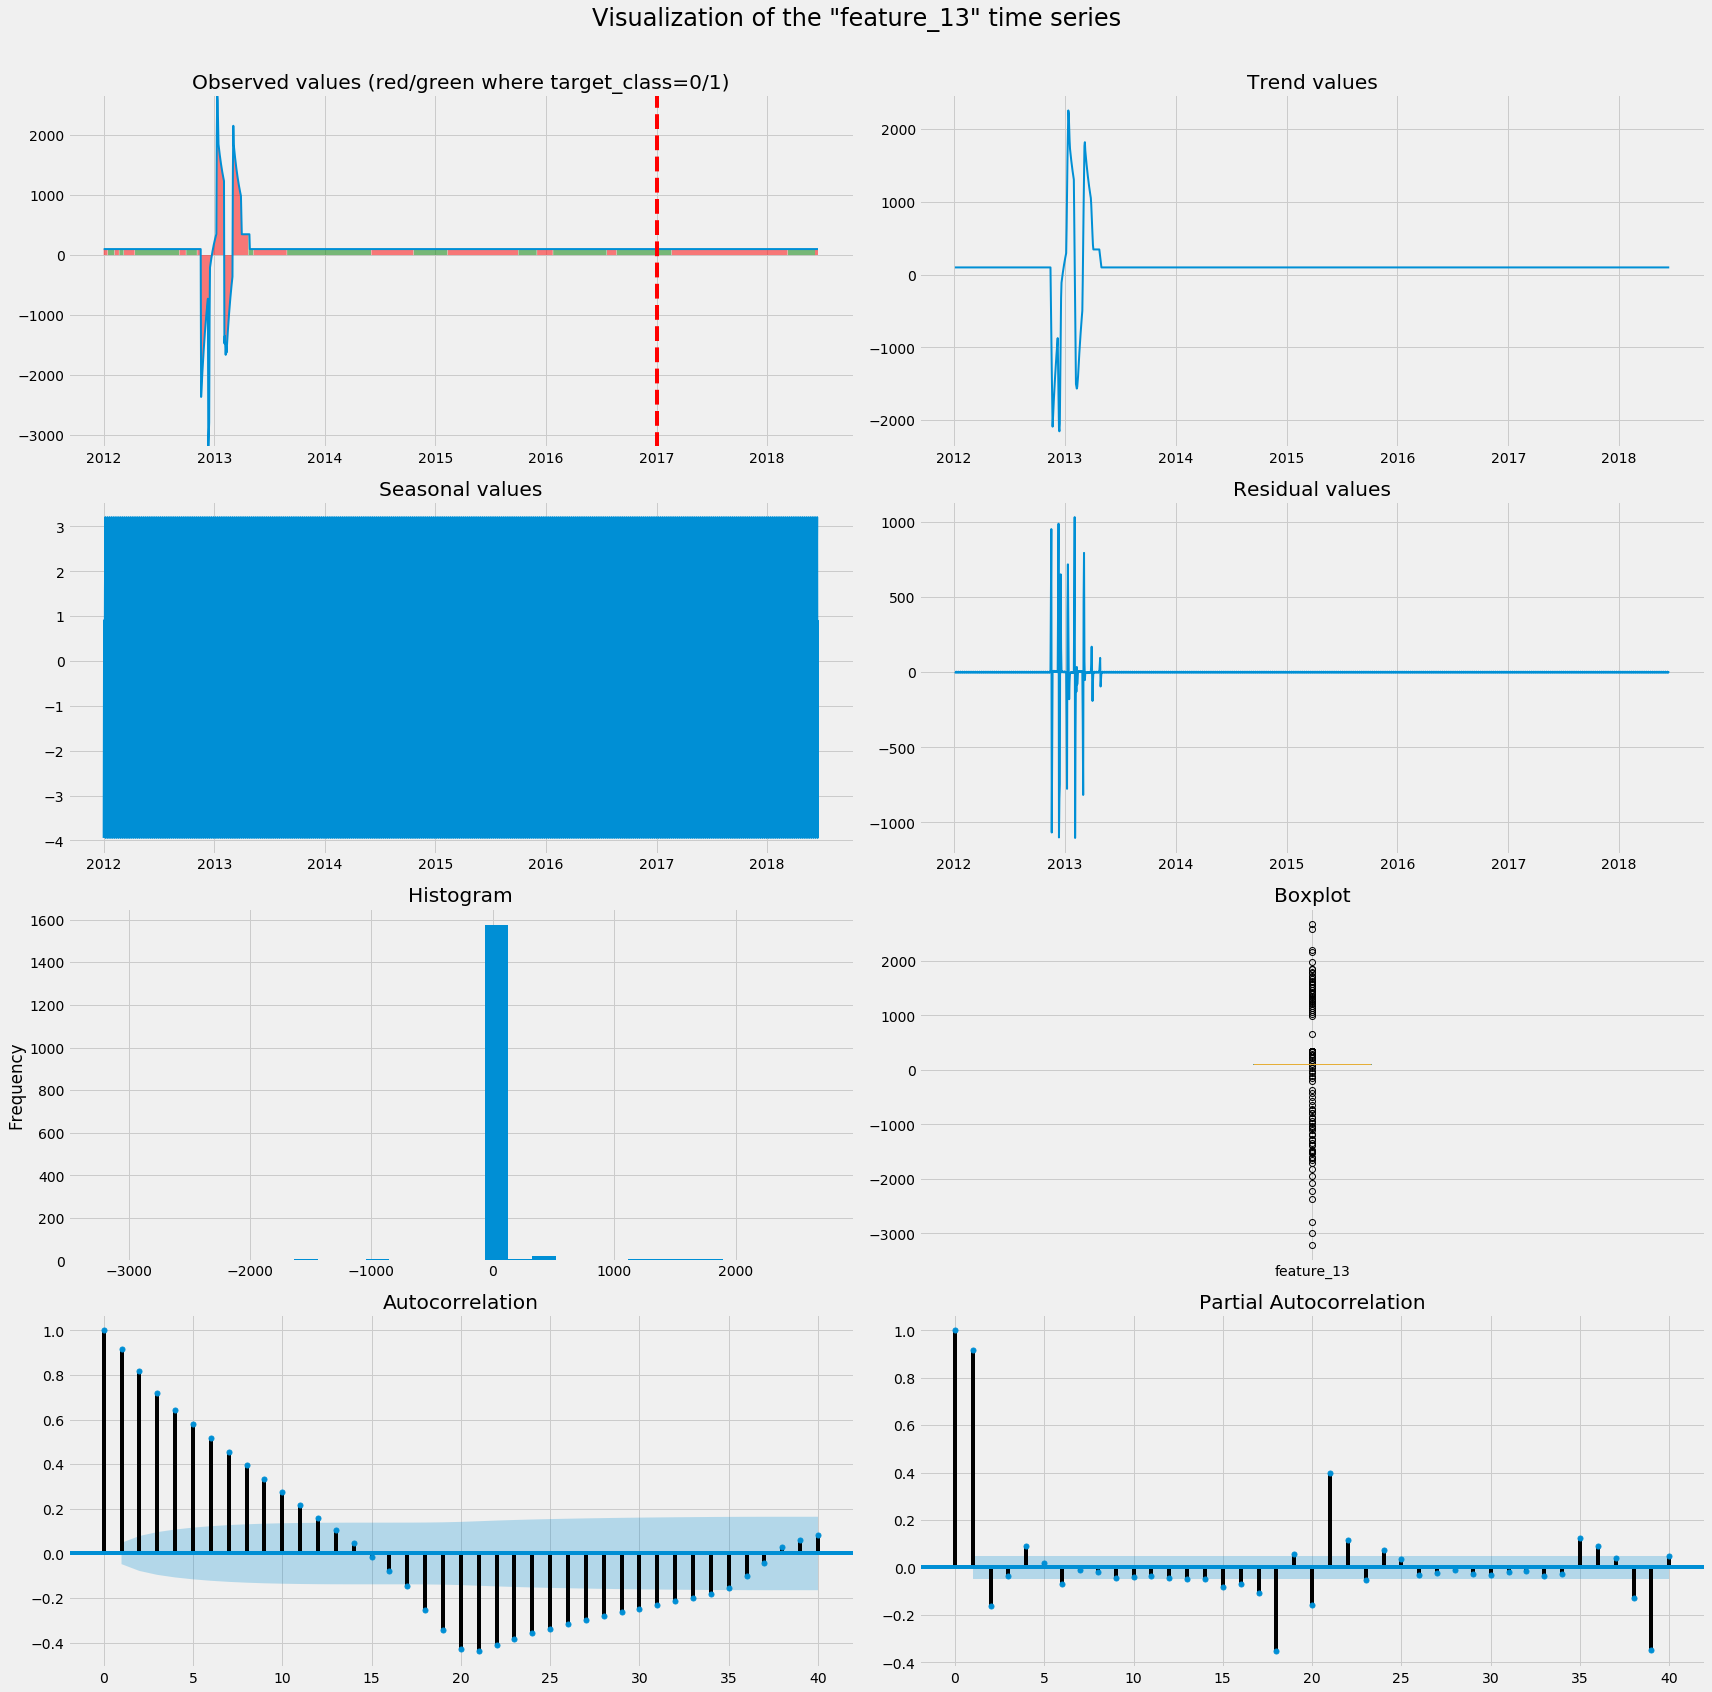

In [58]:
# Call EDA function to explore the time series
eda(df, 'feature_13')

# <a name="feature_14"></a> A-14. feature_14
[Back to INDEX](#index)

Statistic of feature_14 time series
count    1687.000000
mean      100.000267
std         0.006999
min        99.981590
25%        99.995920
50%        99.999820
75%       100.003575
max       100.029420
Name: feature_14, dtype: float64


/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


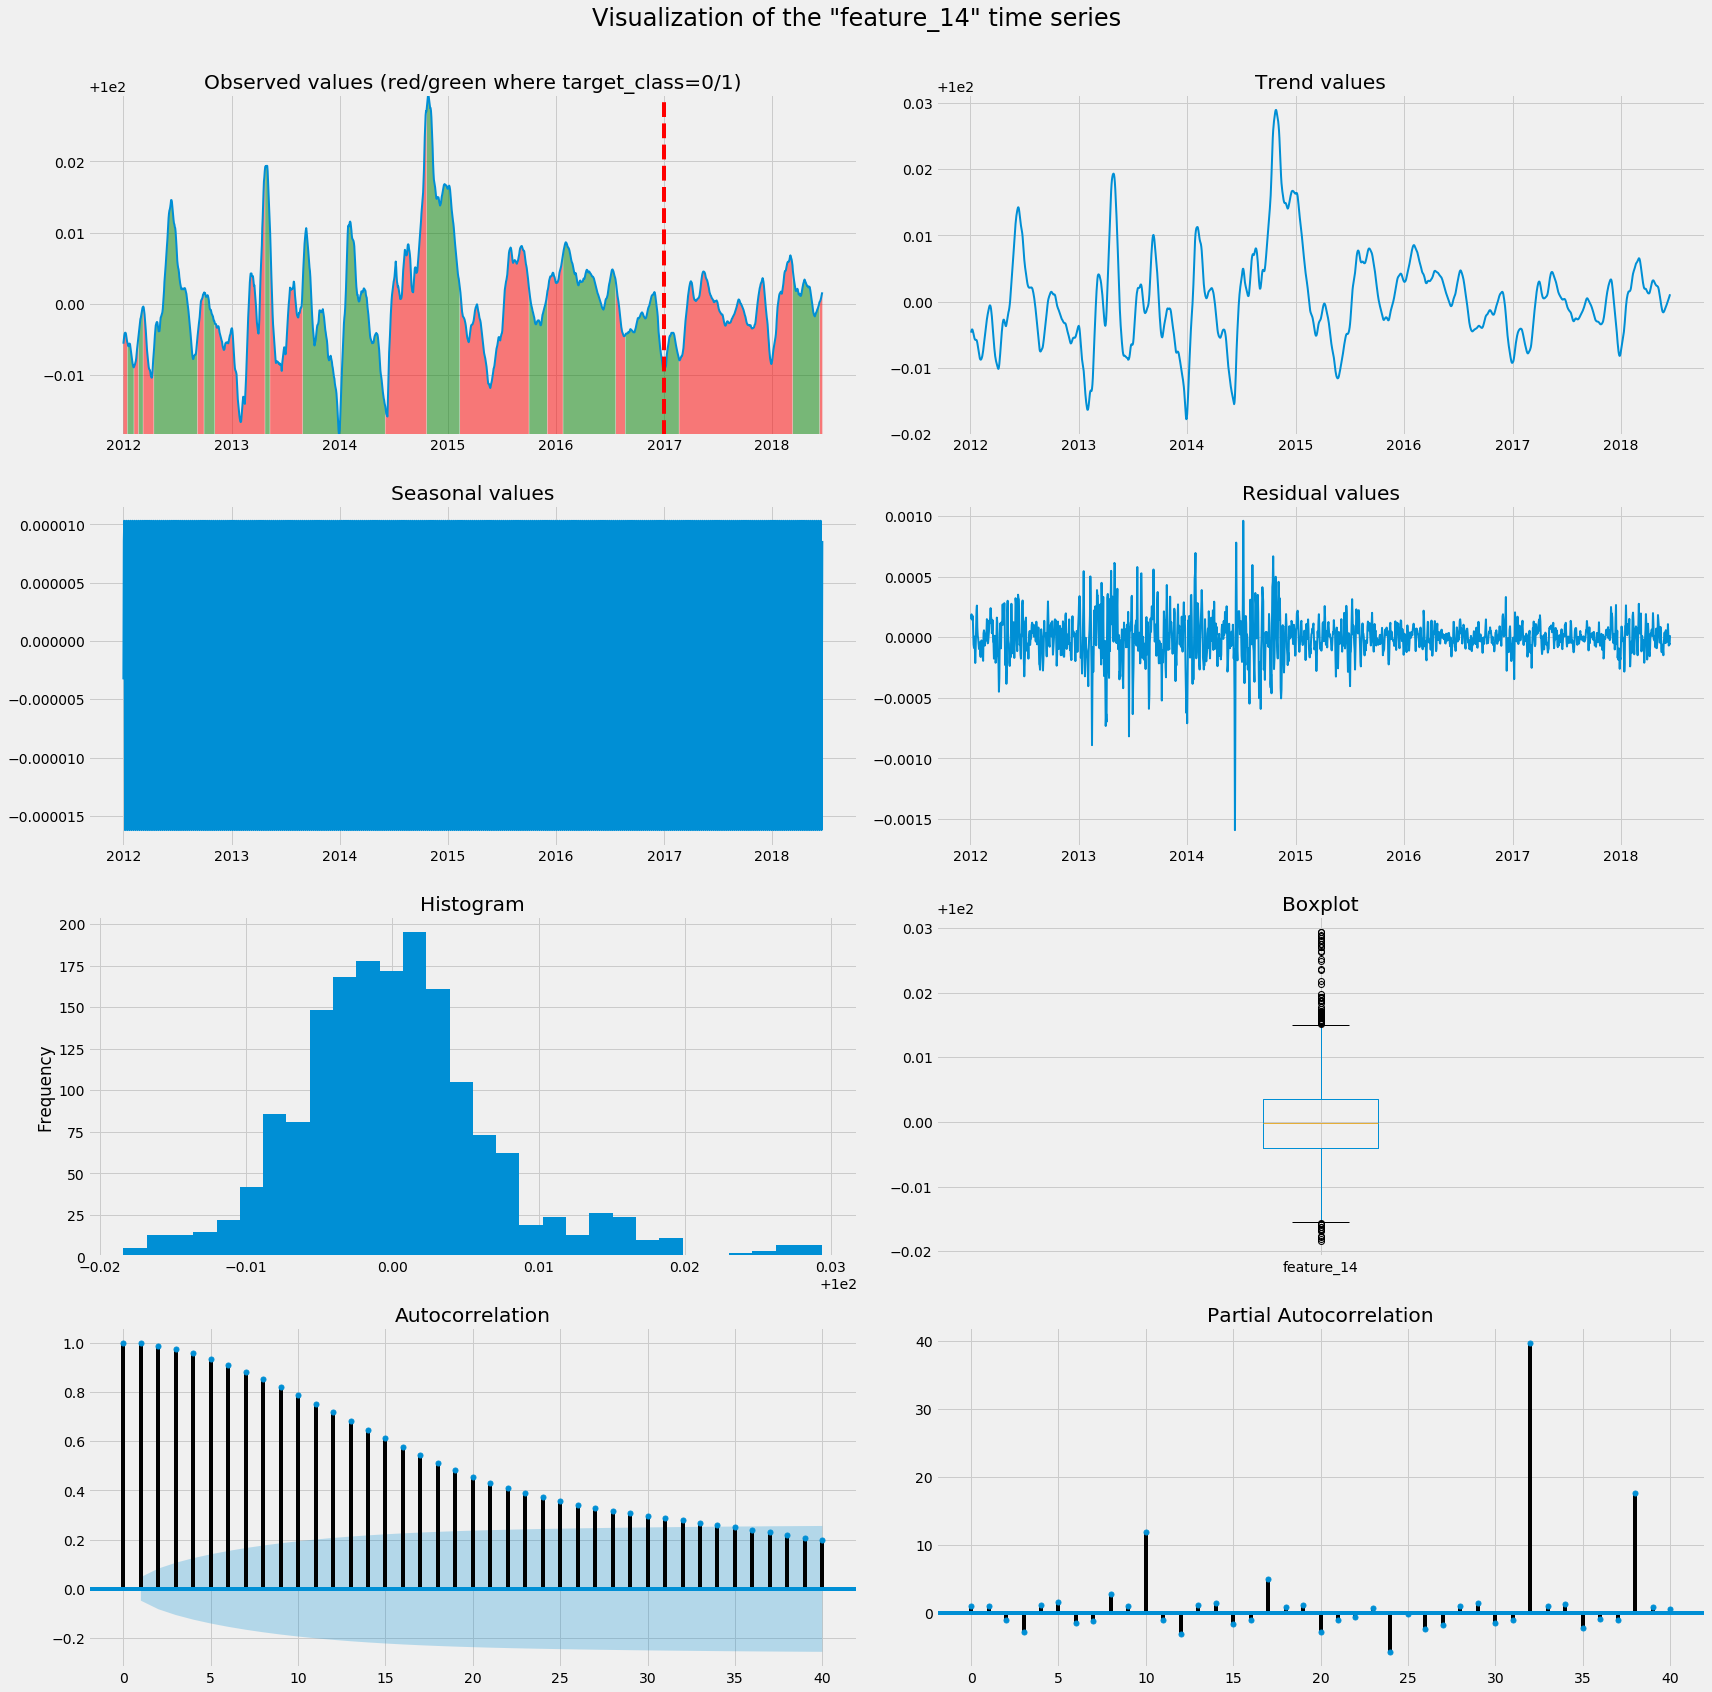

In [59]:
# Call EDA function to explore the time series
eda(df, 'feature_14')

# <a name="feature_15"></a> A-15. feature_15
[Back to INDEX](#index)

Statistic of feature_15 time series
count    1687.000000
mean      100.007692
std         0.065032
min        99.808770
25%        99.971110
50%       100.012910
75%       100.048680
max       100.225190
Name: feature_15, dtype: float64


/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


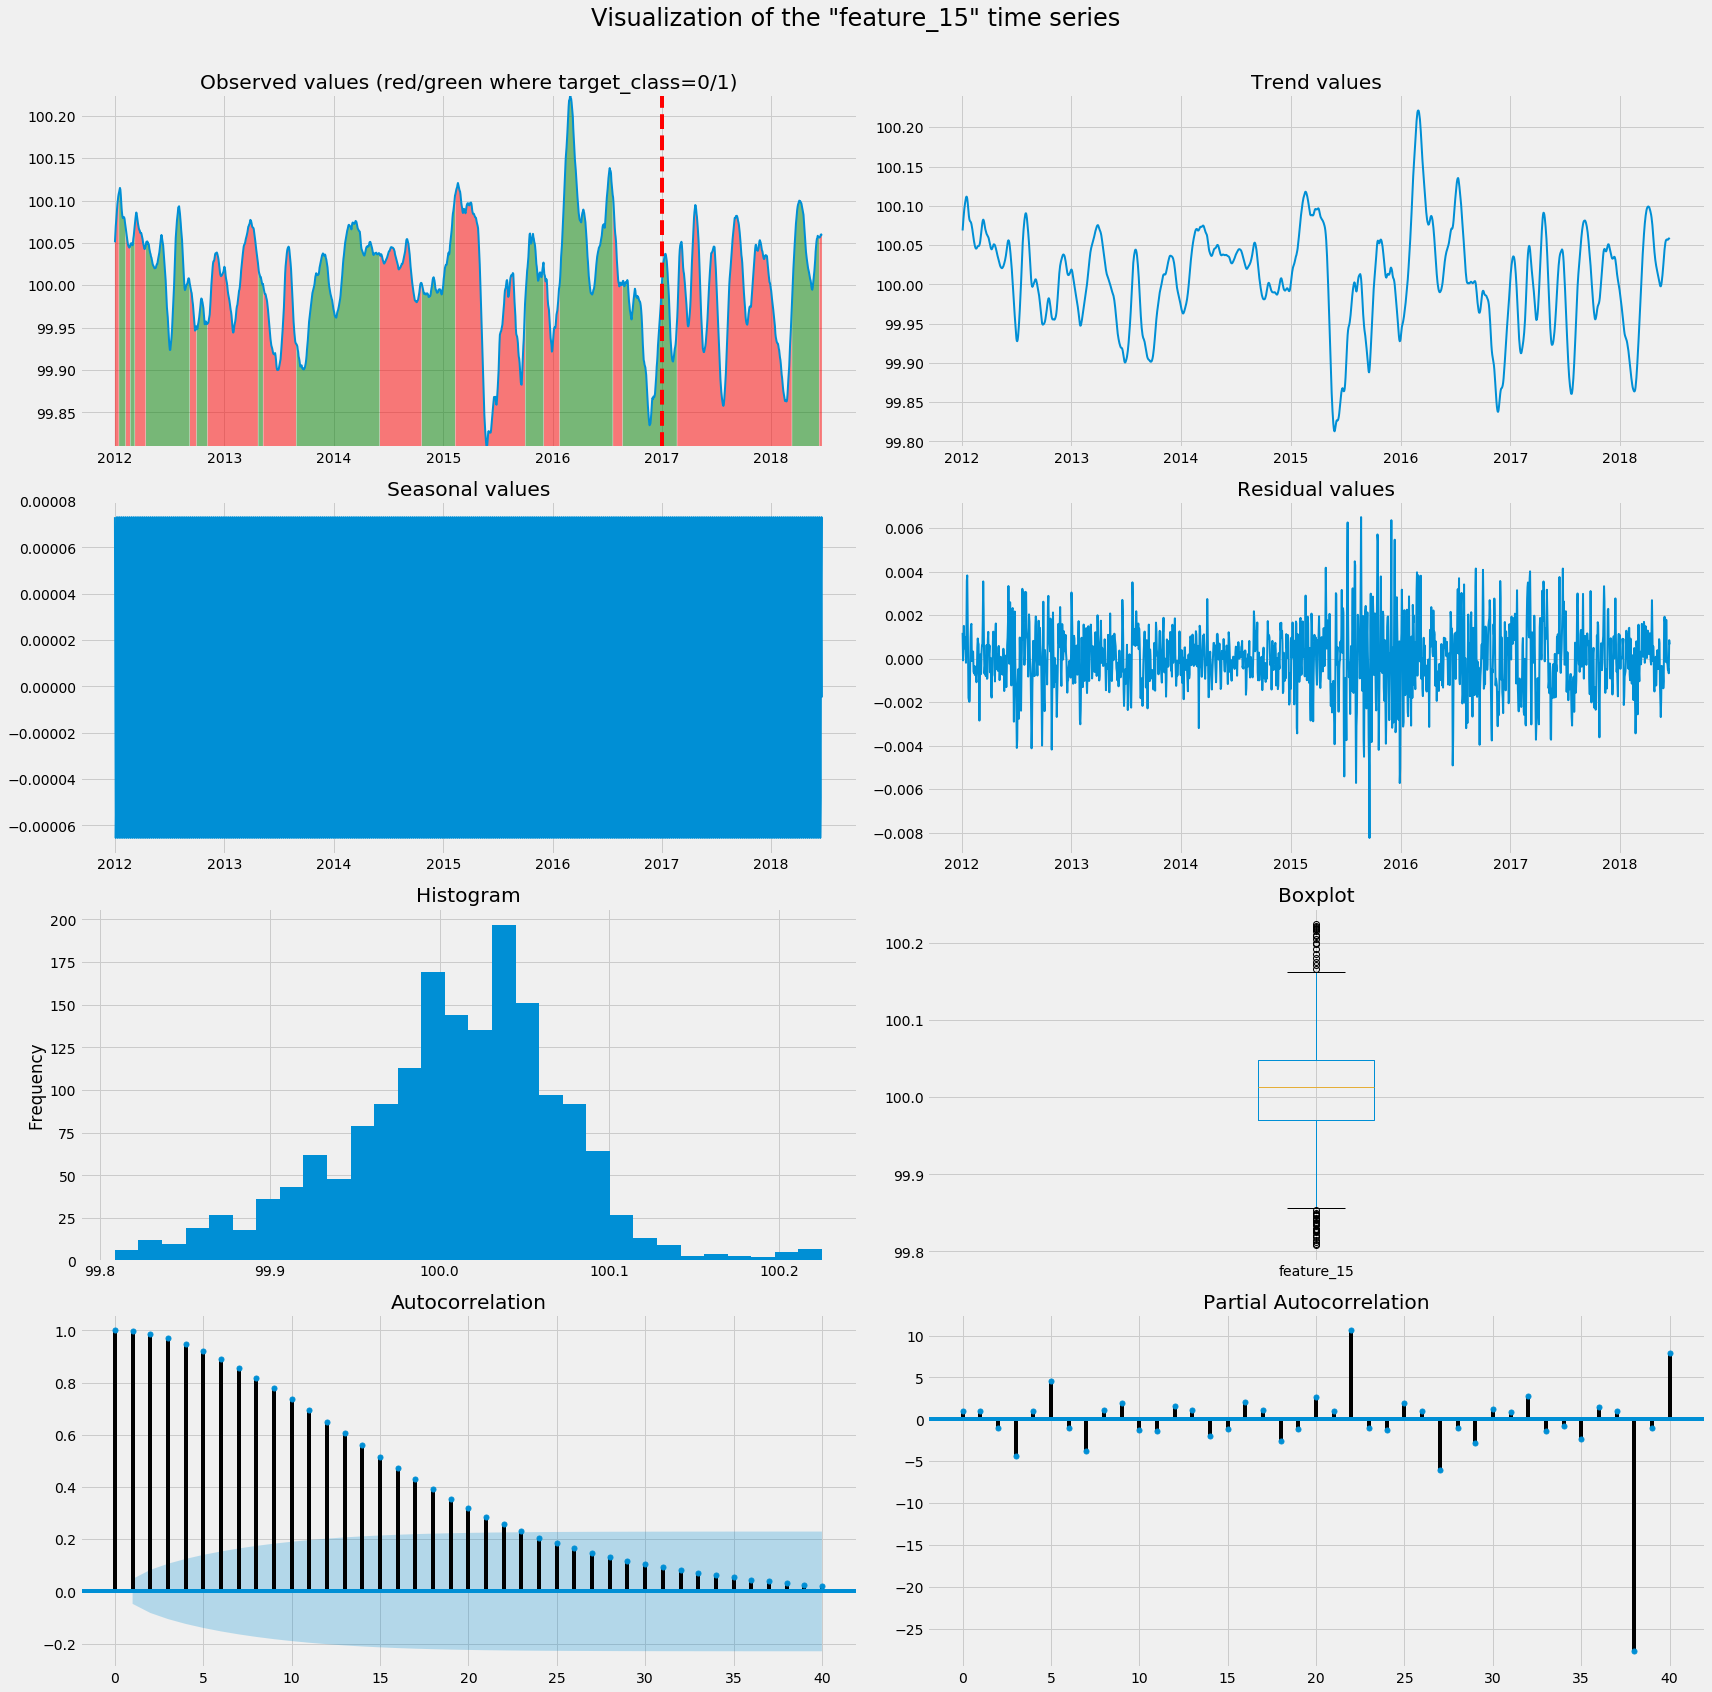

In [60]:
# Call EDA function to explore the time series
eda(df, 'feature_15')

# <a name="feature_16"></a> A-16. feature_16
[Back to INDEX](#index)

Statistic of feature_16 time series
count    1687.000000
mean      100.000201
std         0.002521
min        99.992860
25%        99.998700
50%        99.999980
75%       100.001530
max       100.009500
Name: feature_16, dtype: float64


/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


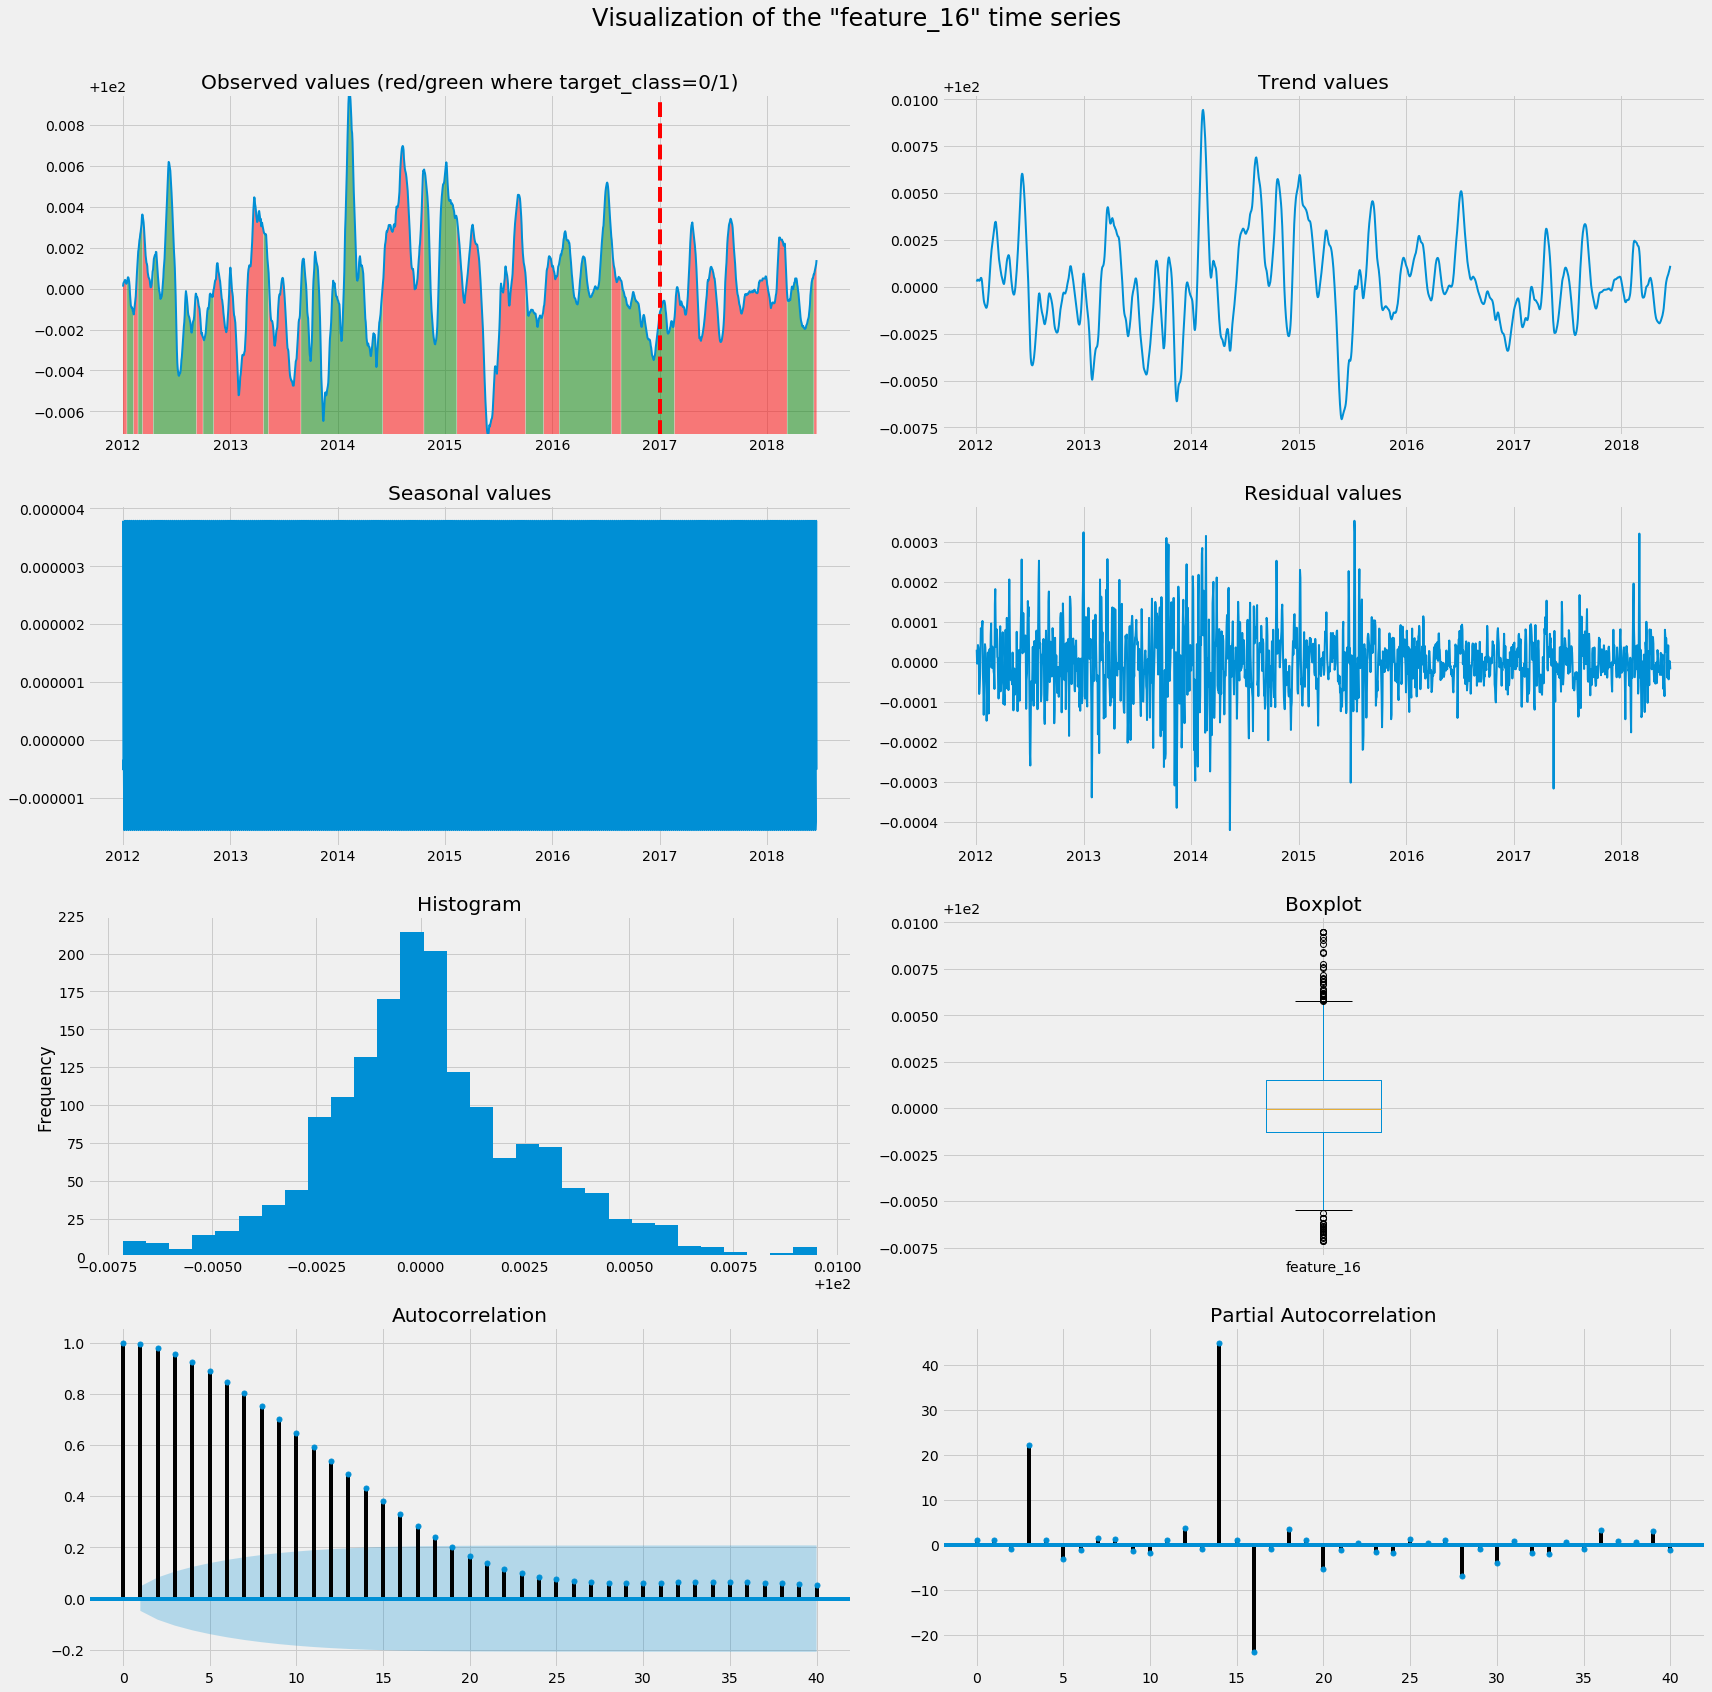

In [61]:
# Call EDA function to explore the time series
eda(df, 'feature_16')